In [2]:
!pip install fastbook

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 kB 38.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.0/47.0 kB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.9/240.9 kB 49.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.1/67.1 kB 20.6 MB/s eta 0:00:00
--- Logging error ---
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/pip/_internal/utils/logging.py", line 177, in emit
    self.console.print(renderable, overflow="ignore", crop=False, style=style)
  File "/usr/local/lib/python3.9/dist-packages/pip/_vendor/rich/console.py", line 1673, in print
    extend(render(renderable, render_options))
  File "/usr/local/lib/python3.9/dist-packages/pip/_vendor/rich/console.py", line 1305, in render
    for render_output in iter_render:
  File "/usr/local/lib/python3.9/dist-packages/pip/_internal/utils/logging.py", line 134, in __rich_console__
    for line in lines:
  File "/usr/local/lib/python

In [3]:
from fastbook import *

In [4]:
pd.options.mode.chained_assignment = None

# Download 3 External Mutation CSV
We download three external datasets from Jinyuan sun GitHub [here][1] with discussion [here][2]

[1]: https://github.com/JinyuanSun/mutation-stability-data
[2]: https://www.kaggle.com/competitions/novozymes-enzyme-stability-prediction/discussion/356182

In [5]:
import os, numpy as np, gc, seaborn as sns
from scipy.stats import spearmanr, pearsonr, rankdata
import matplotlib.pyplot as plt
import pandas as pd

In [29]:
kaggle = pd.read_csv('train_data/NOVO_train_repaired_df.csv')

In [30]:
kaggle.rename(columns={'WT_group': 'PDB'},inplace=True)

In [33]:
kaggle.rename(columns={'WT':'wildtype','MUT':'mutation'},inplace=True)

In [34]:
kaggle.columns

Index(['PDB', 'wildtype', 'position', 'mutation', 'sequence', 'mutant_seq',
       'pH', 'df_sourse', 'data_source', 'source_df_id', 'tm', 'CIF', 'wt_tm',
       'dTm'],
      dtype='object')

In [35]:
kaggle.head(3)

,PDB,wildtype,position,mutation,sequence,mutant_seq,pH,df_sourse,data_source,source_df_id,tm,CIF,wt_tm,dTm
0,GP27,I,29,A,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDRFKHLKTEAEMKASEDLKKHGVTVLTALGAILKKKGHHEAELKPLAQSHATKHKIPIKYLEFISEAIIHVLHSRHPGDFGADAQGAMNKALELFRKDIAAKYKELGYQG,MVLSEGEWQLVLHVWAKVEADVAGHGQDALIRLFKSHPETLEKFDRFKHLKTEAEMKASEDLKKHGVTVLTALGAILKKKGHHEAELKPLAQSHATKHKIPIKYLEFISEAIIHVLHSRHPGDFGADAQGAMNKALELFRKDIAAKYKELGYQG,11.0,NESP train,10.1021/bi00210a011,28801.0,72.1,AF-P02185-F1,76.5,-4.4
1,GP27,L,30,A,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDRFKHLKTEAEMKASEDLKKHGVTVLTALGAILKKKGHHEAELKPLAQSHATKHKIPIKYLEFISEAIIHVLHSRHPGDFGADAQGAMNKALELFRKDIAAKYKELGYQG,MVLSEGEWQLVLHVWAKVEADVAGHGQDIAIRLFKSHPETLEKFDRFKHLKTEAEMKASEDLKKHGVTVLTALGAILKKKGHHEAELKPLAQSHATKHKIPIKYLEFISEAIIHVLHSRHPGDFGADAQGAMNKALELFRKDIAAKYKELGYQG,11.0,NESP train,10.1021/bi00210a011,28805.0,67.6,AF-P02185-F1,76.5,-8.9
2,GP27,L,30,I,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDRFKHLKTEAEMKASEDLKKHGVTVLTALGAILKKKGHHEAELKPLAQSHATKHKIPIKYLEFISEAIIHVLHSRHPGDFGADAQGAMNKALELFRKDIAAKYKELGYQG,MVLSEGEWQLVLHVWAKVEADVAGHGQDIIIRLFKSHPETLEKFDRFKHLKTEAEMKASEDLKKHGVTVLTALGAILKKKGHHEAELKPLAQSHATKHKIPIKYLEFISEAIIHVLHSRHPGDFGADAQGAMNKALELFRKDIAAKYKELGYQG,11.0,NESP train,10.1021/bi00210a011,28807.0,72.9,AF-P02185-F1,76.5,-3.6


In [36]:
test = pd.read_csv('train_data/test.csv')

In [37]:
test['sequence'] = 'VPVNPEPDATSVENVALKTGSGDSQSDPIKADLEVKGQSALPFDVDCWAILCKGAPNVLQRVNEKTKNSNRDRSGANKGPFKDPQKWGIKALPPKNPSWSAQDFKSPEEYAFASSLQGGTNAILAPVNLASQNSQGGVLNGFYSANKVAQFDPSKPQQTKGTWFQITKFTGAAGPYCKALGSNDKSVCDKNKNIAGDWGFDPAKWAYQYDEKNNKFNYVGK'

In [38]:
test.rename(columns = {'protein_sequence':'mutant_seq'},inplace=True)

In [39]:
def get_test_mutation(row):
    for i,(a,b) in enumerate(zip(row.mutant_seq,row.sequence)):
        if a!=b: break
    row['wildtype'] = row.sequence[i]
    row['mutation'] = row.mutant_seq[i]
    row['position'] = i+1
    return row

In [40]:
test = test.apply(get_test_mutation,axis=1)


In [41]:
test['ddG'] = np.nan
test['dTm'] = np.nan
test['normalized_dTm'] = np.nan
test['normalized_ddG'] = np.nan
test['CIF'] = None
test['source'] = 'test'
test['PDB'] = 'test'

In [42]:
test.head(3)

,seq_id,mutant_seq,pH,data_source,sequence,wildtype,mutation,position,ddG,dTm,normalized_dTm,normalized_ddG,CIF,source,PDB
0,31390,VPVNPEPDATSVENVAEKTGSGDSQSDPIKADLEVKGQSALPFDVDCWAILCKGAPNVLQRVNEKTKNSNRDRSGANKGPFKDPQKWGIKALPPKNPSWSAQDFKSPEEYAFASSLQGGTNAILAPVNLASQNSQGGVLNGFYSANKVAQFDPSKPQQTKGTWFQITKFTGAAGPYCKALGSNDKSVCDKNKNIAGDWGFDPAKWAYQYDEKNNKFNYVGK,8,Novozymes,VPVNPEPDATSVENVALKTGSGDSQSDPIKADLEVKGQSALPFDVDCWAILCKGAPNVLQRVNEKTKNSNRDRSGANKGPFKDPQKWGIKALPPKNPSWSAQDFKSPEEYAFASSLQGGTNAILAPVNLASQNSQGGVLNGFYSANKVAQFDPSKPQQTKGTWFQITKFTGAAGPYCKALGSNDKSVCDKNKNIAGDWGFDPAKWAYQYDEKNNKFNYVGK,L,E,17,NaN,NaN,NaN,NaN,None,test,test
1,31391,VPVNPEPDATSVENVAKKTGSGDSQSDPIKADLEVKGQSALPFDVDCWAILCKGAPNVLQRVNEKTKNSNRDRSGANKGPFKDPQKWGIKALPPKNPSWSAQDFKSPEEYAFASSLQGGTNAILAPVNLASQNSQGGVLNGFYSANKVAQFDPSKPQQTKGTWFQITKFTGAAGPYCKALGSNDKSVCDKNKNIAGDWGFDPAKWAYQYDEKNNKFNYVGK,8,Novozymes,VPVNPEPDATSVENVALKTGSGDSQSDPIKADLEVKGQSALPFDVDCWAILCKGAPNVLQRVNEKTKNSNRDRSGANKGPFKDPQKWGIKALPPKNPSWSAQDFKSPEEYAFASSLQGGTNAILAPVNLASQNSQGGVLNGFYSANKVAQFDPSKPQQTKGTWFQITKFTGAAGPYCKALGSNDKSVCDKNKNIAGDWGFDPAKWAYQYDEKNNKFNYVGK,L,K,17,NaN,NaN,NaN,NaN,None,test,test
2,31392,VPVNPEPDATSVENVAKTGSGDSQSDPIKADLEVKGQSALPFDVDCWAILCKGAPNVLQRVNEKTKNSNRDRSGANKGPFKDPQKWGIKALPPKNPSWSAQDFKSPEEYAFASSLQGGTNAILAPVNLASQNSQGGVLNGFYSANKVAQFDPSKPQQTKGTWFQITKFTGAAGPYCKALGSNDKSVCDKNKNIAGDWGFDPAKWAYQYDEKNNKFNYVGK,8,Novozymes,VPVNPEPDATSVENVALKTGSGDSQSDPIKADLEVKGQSALPFDVDCWAILCKGAPNVLQRVNEKTKNSNRDRSGANKGPFKDPQKWGIKALPPKNPSWSAQDFKSPEEYAFASSLQGGTNAILAPVNLASQNSQGGVLNGFYSANKVAQFDPSKPQQTKGTWFQITKFTGAAGPYCKALGSNDKSVCDKNKNIAGDWGFDPAKWAYQYDEKNNKFNYVGK,L,K,17,NaN,NaN,NaN,NaN,None,test,test


In [43]:
df = pd.concat([kaggle,test])

In [44]:
cols = ['PDB','wildtype','position','mutation','sequence','mutant_seq','pH','dTm','source']

In [45]:
df = df[cols].reset_index(drop=True)

In [46]:
df['len_wt'] =df.sequence.transform(len)
df['len_mut'] = df.mutant_seq.transform(len)

In [47]:
df['diff_len'] = df['len_wt'] -df['len_mut']

In [48]:
df.loc[df['diff_len'] == 1,'mut_type'] = 'deletion'

In [49]:
df.loc[df['diff_len'] == 0,'mut_type'] = 'sub'

In [50]:
df[df.PDB!='test'].shape

(986, 13)

In [51]:
df[df.PDB=='test'].shape

(2413, 13)

# AF feature

In [52]:
!pip install -q biopandas
from biopandas.pdb import PandasPdb

--- Logging error ---
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/pip/_internal/utils/logging.py", line 177, in emit
    self.console.print(renderable, overflow="ignore", crop=False, style=style)
  File "/usr/local/lib/python3.9/dist-packages/pip/_vendor/rich/console.py", line 1673, in print
    extend(render(renderable, render_options))
  File "/usr/local/lib/python3.9/dist-packages/pip/_vendor/rich/console.py", line 1305, in render
    for render_output in iter_render:
  File "/usr/local/lib/python3.9/dist-packages/pip/_internal/utils/logging.py", line 134, in __rich_console__
    for line in lines:
  File "/usr/local/lib/python3.9/dist-packages/pip/_vendor/rich/segment.py", line 249, in split_lines
    for segment in segments:
  File "/usr/local/lib/python3.9/dist-packages/pip/_vendor/rich/console.py", line 1283, in render
    renderable = rich_cast(renderable)
  File "/usr/local/lib/python3.9/dist-packages/pip/_vendor/rich/protocol.py", line 36

In [59]:
kaggle_mut = []
names = []
for i,r in df[df.PDB!='test'].iterrows():
    a = PandasPdb().read_pdb(f'pdb/{r.PDB}_{r.wildtype}{r.position}{r.mutation}_unrelaxed_rank_1_model_3.pdb').df['ATOM']
    kaggle_mut.append(a.groupby('residue_number').b_factor.agg('first').values)
    names.append(f'{r.PDB}_{r.wildtype}{r.position}{r.mutation}')

In [60]:
kaggle_mutant = pd.DataFrame(kaggle_mut,index=names)

In [74]:
kaggle_mutant.to_csv('kaggle_mutant.csv')

In [65]:
for i in df[df.PDB!='test'].PDB.unique():
    break

In [70]:
kaggle_wt = []
names = []
for i in df[df.PDB!='test'].PDB.unique():
    a = PandasPdb().read_pdb(f'pdb_WT/{i}_unrelaxed_rank_1_model_3.pdb').df['ATOM']
    kaggle_wt.append(a.groupby('residue_number').b_factor.agg('first').values)
    names.append(i)

In [71]:
kaggle_wt = pd.DataFrame(kaggle_wt,index=names)

In [73]:
kaggle_wt.to_csv('kaggle_wt.csv')

In [78]:
test_mut = pd.read_csv('test_mut.csv',index_col = 0)

In [80]:
test_wt = []
names = []
for i in range(1):
    a = PandasPdb().read_pdb('AF_test.pdb').df['ATOM']
    test_wt.append(a.groupby('residue_number').b_factor.agg('first').values)
    names.append('test')

In [82]:
test_wt = pd.DataFrame(test_wt,index=names)

In [91]:
test_mut = []
names = []
for i,r in df[df.PDB=='test'].iterrows():
    a = PandasPdb().read_pdb(f'pdb_test/{r.wildtype}{r.position}{r.mutation}_unrelaxed_rank_1_model_3.pdb').df['ATOM']
    test_mut.append(a.groupby('residue_number').b_factor.agg('first').values)
    names.append(f'{r.PDB}_{r.wildtype}{r.position}{r.mutation}')

FileNotFoundError: [Errno 2] No such file or directory: 'pdb_test/T19A_unrelaxed_rank_1_model_3.pdb'

In [119]:
kaggle_mut = kaggle_mutant.copy()

In [122]:
test_mut.index

Index(['L17E', 'L17K', 'L17_', 'K18C', 'K18F', 'K18G', 'K18H', 'K18I', 'T19A',
       'T19C',
       ...
       'A16C', 'A16D', 'A16F', 'A16G', 'A16H', 'A16I', 'A16L', 'A16N', 'A16P',
       'A16W'],
      dtype='object', length=2412)

In [123]:
df

,PDB,wildtype,position,mutation,sequence,mutant_seq,pH,dTm,source,len_wt,len_mut,diff_len,mut_type,name1,name2
0,GP27,I,29,A,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDRFKHLKTEAEMKASEDLKKHGVTVLTALGAILKKKGHHEAELKPLAQSHATKHKIPIKYLEFISEAIIHVLHSRHPGDFGADAQGAMNKALELFRKDIAAKYKELGYQG,MVLSEGEWQLVLHVWAKVEADVAGHGQDALIRLFKSHPETLEKFDRFKHLKTEAEMKASEDLKKHGVTVLTALGAILKKKGHHEAELKPLAQSHATKHKIPIKYLEFISEAIIHVLHSRHPGDFGADAQGAMNKALELFRKDIAAKYKELGYQG,11.0,-4.4,NaN,154,154,0,sub,GP27_I29A,I29A
1,GP27,L,30,A,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDRFKHLKTEAEMKASEDLKKHGVTVLTALGAILKKKGHHEAELKPLAQSHATKHKIPIKYLEFISEAIIHVLHSRHPGDFGADAQGAMNKALELFRKDIAAKYKELGYQG,MVLSEGEWQLVLHVWAKVEADVAGHGQDIAIRLFKSHPETLEKFDRFKHLKTEAEMKASEDLKKHGVTVLTALGAILKKKGHHEAELKPLAQSHATKHKIPIKYLEFISEAIIHVLHSRHPGDFGADAQGAMNKALELFRKDIAAKYKELGYQG,11.0,-8.9,NaN,154,154,0,sub,GP27_L30A,L30A
2,GP27,L,30,I,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDRFKHLKTEAEMKASEDLKKHGVTVLTALGAILKKKGHHEAELKPLAQSHATKHKIPIKYLEFISEAIIHVLHSRHPGDFGADAQGAMNKALELFRKDIAAKYKELGYQG,MVLSEGEWQLVLHVWAKVEADVAGHGQDIIIRLFKSHPETLEKFDRFKHLKTEAEMKASEDLKKHGVTVLTALGAILKKKGHHEAELKPLAQSHATKHKIPIKYLEFISEAIIHVLHSRHPGDFGADAQGAMNKALELFRKDIAAKYKELGYQG,11.0,-3.6,NaN,154,154,0,sub,GP27_L30I,L30I
3,GP27,L,50,I,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDRFKHLKTEAEMKASEDLKKHGVTVLTALGAILKKKGHHEAELKPLAQSHATKHKIPIKYLEFISEAIIHVLHSRHPGDFGADAQGAMNKALELFRKDIAAKYKELGYQG,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDRFKHIKTEAEMKASEDLKKHGVTVLTALGAILKKKGHHEAELKPLAQSHATKHKIPIKYLEFISEAIIHVLHSRHPGDFGADAQGAMNKALELFRKDIAAKYKELGYQG,11.0,-2.5,NaN,154,154,0,sub,GP27_L50I,L50I
4,GP27,L,70,A,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDRFKHLKTEAEMKASEDLKKHGVTVLTALGAILKKKGHHEAELKPLAQSHATKHKIPIKYLEFISEAIIHVLHSRHPGDFGADAQGAMNKALELFRKDIAAKYKELGYQG,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDRFKHLKTEAEMKASEDLKKHGVTVATALGAILKKKGHHEAELKPLAQSHATKHKIPIKYLEFISEAIIHVLHSRHPGDFGADAQGAMNKALELFRKDIAAKYKELGYQG,11.0,-3.8,NaN,154,154,0,sub,GP27_L70A,L70A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3394,test,A,16,I,VPVNPEPDATSVENVALKTGSGDSQSDPIKADLEVKGQSALPFDVDCWAILCKGAPNVLQRVNEKTKNSNRDRSGANKGPFKDPQKWGIKALPPKNPSWSAQDFKSPEEYAFASSLQGGTNAILAPVNLASQNSQGGVLNGFYSANKVAQFDPSKPQQTKGTWFQITKFTGAAGPYCKALGSNDKSVCDKNKNIAGDWGFDPAKWAYQYDEKNNKFNYVGK,VPVNPEPDATSVENVILKTGSGDSQSDPIKADLEVKGQSALPFDVDCWAILCKGAPNVLQRVNEKTKNSNRDRSGANKGPFKDPQKWGIKALPPKNPSWSAQDFKSPEEYAFASSLQGGTNAILAPVNLASQNSQGGVLNGFYSANKVAQFDPSKPQQTKGTWFQITKFTGAAGPYCKALGSNDKSVCDKNKNIAGDWGFDPAKWAYQYDEKNNKFNYVGK,8.0,NaN,test,221,221,0,sub,test_A16I,A16I
3395,test,A,16,L,VPVNPEPDATSVENVALKTGSGDSQSDPIKADLEVKGQSALPFDVDCWAILCKGAPNVLQRVNEKTKNSNRDRSGANKGPFKDPQKWGIKALPPKNPSWSAQDFKSPEEYAFASSLQGGTNAILAPVNLASQNSQGGVLNGFYSANKVAQFDPSKPQQTKGTWFQITKFTGAAGPYCKALGSNDKSVCDKNKNIAGDWGFDPAKWAYQYDEKNNKFNYVGK,VPVNPEPDATSVENVLLKTGSGDSQSDPIKADLEVKGQSALPFDVDCWAILCKGAPNVLQRVNEKTKNSNRDRSGANKGPFKDPQKWGIKALPPKNPSWSAQDFKSPEEYAFASSLQGGTNAILAPVNLASQNSQGGVLNGFYSANKVAQFDPSKPQQTKGTWFQITKFTGAAGPYCKALGSNDKSVCDKNKNIAGDWGFDPAKWAYQYDEKNNKFNYVGK,8.0,NaN,test,221,221,0,sub,test_A16L,A16L
3396,test,A,16,N,VPVNPEPDATSVENVALKTGSGDSQSDPIKADLEVKGQSALPFDVDCWAILCKGAPNVLQRVNEKTKNSNRDRSGANKGPFKDPQKWGIKALPPKNPSWSAQDFKSPEEYAFASSLQGGTNAILAPVNLASQNSQGGVLNGFYSANKVAQFDPSKPQQTKGTWFQITKFTGAAGPYCKALGSNDKSVCDKNKNIAGDWGFDPAKWAYQYDEKNNKFNYVGK,VPVNPEPDATSVENVNLKTGSGDSQSDPIKADLEVKGQSALPFDVDCWAILCKGAPNVLQRVNEKTKNSNRDRSGANKGPFKDPQKWGIKALPPKNPSWSAQDFKSPEEYAFASSLQGGTNAILAPVNLASQNSQGGVLNGFYSANKVAQFDPSKPQQTKGTWFQITKFTGAAGPYCKALGSNDKSVCDKNKNIAGDWGFDPAKWAYQYDEKNNKFNYVGK,8.0,NaN,test,221,221,0,sub,test_A16N,A16N
3397,test,A,16,P,VPVNPEPDATSVENVALKTGSGDSQSDPIKADLEVKGQSALPFDVDCWAILCKGAPNVLQRVNEKTKNSNRDRSGANKGPFKDPQKWGIKALPPKNPSWSAQDFKSPEEYAFASSLQGGTNAILAPVNLASQNSQGGVLNGFYSANKVAQFDPSKPQQTKGTWFQITKFTGAAGPYCKALGSNDKSVCDKNKNIAGDWGFDPAKWAYQYDEKNNKFNYVGK,VPVNPEPDATSVENVPLKTGSGDSQSDPIKADLEVKGQSALPFDVDCWAILCKGAPNVLQRVNEKTKNSNRDRSGANKGPFKDPQKWGIKALPPKNPSWSAQDFKSPEEYAFASSLQGGTNAILAPVNLASQNSQGGVLNGFYSANKVAQFDPSKPQQTKGTWFQITKFTGAAGPYCKALGSNDKSVCDKNKNIAGDWGFDPAKWAYQYDEKNNKFNYVGK,8.0,NaN,test,221,221

In [ ]:
df[]

In [124]:
df['name'] = df.apply(lambda r: f'{r.PDB}_{r.wildtype}{r.position}{r.mutation}' if r.PDB!='test' else f'{r.wildtype}{r.position}{r.mutation}' ,axis=1)

In [129]:
df[df.name == 'K221K']

,PDB,wildtype,position,mutation,sequence,mutant_seq,pH,dTm,source,len_wt,len_mut,diff_len,mut_type,name1,name2,name
2155,test,K,221,K,VPVNPEPDATSVENVALKTGSGDSQSDPIKADLEVKGQSALPFDVDCWAILCKGAPNVLQRVNEKTKNSNRDRSGANKGPFKDPQKWGIKALPPKNPSWSAQDFKSPEEYAFASSLQGGTNAILAPVNLASQNSQGGVLNGFYSANKVAQFDPSKPQQTKGTWFQITKFTGAAGPYCKALGSNDKSVCDKNKNIAGDWGFDPAKWAYQYDEKNNKFNYVGK,VPVNPEPDATSVENVALKTGSGDSQSDPIKADLEVKGQSALPFDVDCWAILCKGAPNVLQRVNEKTKNSNRDRSGANKGPFKDPQKWGIKALPPKNPSWSAQDFKSPEEYAFASSLQGGTNAILAPVNLASQNSQGGVLNGFYSANKVAQFDPSKPQQTKGTWFQITKFTGAAGPYCKALGSNDKSVCDKNKNIAGDWGFDPAKWAYQYDEKNNKFNYVGK,8.0,NaN,test,221,221,0,sub,test_K221K,K221K,K221K


In [130]:
kaggle_mutant

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536
GP27_I29A,69.35,87.17,95.96,96.87,96.53,97.77,98.09,97.99,98.12,98.29,98.32,98.23,98.05,98.08,98.17,98.16,97.77,98.17,97.84,97.69,98.06,98.20,97.79,97.75,98.52,98.27,98.15,98.30,98.44,98.15,98.01,97.97,98.05,97.31,96.20,96.67,96.52,95.04,94.91,95.72,95.05,92.85,93.11,92.85,92.69,92.19,91.57,92.55,93.86,94.89,90.50,94.45,94.82,96.41,96.91,97.15,96.57,96.88,97.04,95.90,96.25,96.77,97.33,97.88,96.74,97.54,98.31,97.35,96.42,98.27,98.08,97.06,97.66,97.60,97.36,96.71,97.38,97.02,96.76,95.20,91.83,94.04,94.44,93.26,94.50,94.04,94.23,94.06,94.22,94.55,95.33,95.69,94.96,94.83,95.48,93.99,93.29,92.63,93.15,94.89,94.82,93.85,95.04,96.53,95.57,96.25,98.10,97.52,97.65,97.98,98.45,98.40,98.38,98.21,98.19,98.37,97.58,97.19,97.33,97.22,95.85,95.86,95.65,97.62,96.75,97.57,97.54,98.06,98.24,97.99,98.26,98.43,98.02,97.81,97.88,97.58,96.73,96.04,95.12,95.25,95.33,95.31,95.32,95.17,95.22,94.96,96.02,94.67,94.34,94.27,92.84,92.70,77.71,73.69,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

In [96]:
df1 = df[df.PDB!='test']

In [112]:
df2 = df[df.PDB=='test']

In [99]:
df1['AF_position'] = df1.apply(lambda r: kaggle_mutant.loc[r.name1,r.position+1] - kaggle_wt.loc[r.PDB,r.position+1],axis=1)

In [102]:
df1['AF_sum'] = df1.apply(lambda r: (kaggle_mutant.loc[r.name1,:] - kaggle_wt.loc[r.PDB,:]).sum(),axis=1)

In [104]:
df1['AF_position-1'] = df1.apply(lambda r: kaggle_mutant.loc[r.name1,r.position-1] - kaggle_wt.loc[r.PDB,r.position-1],axis=1)

In [105]:
df1['AF_mean'] = df1.apply(lambda r: (kaggle_mutant.loc[r.name1,:] - kaggle_wt.loc[r.PDB,:]).mean(),axis=1)

In [108]:
df1['AF_max'] = df1.apply(lambda r: (kaggle_mutant.loc[r.name1,:] - kaggle_wt.loc[r.PDB,:]).max(),axis=1)

In [109]:
df1['AF_min'] = df1.apply(lambda r: (kaggle_mutant.loc[r.name1,:] - kaggle_wt.loc[r.PDB,:]).min(),axis=1)

In [111]:
df1['AF_median'] = df1.apply(lambda r: (kaggle_mutant.loc[r.name1,:] - kaggle_wt.loc[r.PDB,:]).median(),axis=1)

In [114]:
test_wt

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220
test,45.11,41.54,40.19,42.11,42.39,41.49,42.58,40.36,40.7,39.44,40.63,41.68,42.6,38.11,48.38,55.85,55.23,69.25,85.36,90.73,93.49,95.33,94.12,95.4,96.15,96.88,96.8,97.78,97.52,97.27,96.27,95.56,97.05,97.46,98.17,95.8,92.85,95.67,97.7,98.3,98.54,98.55,98.63,98.66,98.61,98.6,98.65,98.62,98.56,98.42,98.12,98.22,97.65,96.51,97.99,97.71,97.24,98.3,98.45,97.65,97.32,97.85,96.74,97.09,97.72,98.08,98.1,98.26,98.23,98.55,98.31,98.03,97.96,98.12,98.02,97.89,97.4,97.17,97.17,97.69,98.05,97.38,95.39,97.1,96.84,97.07,96.58,95.66,96.52,95.85,97.39,97.75,96.92,94.1,93.95,94.49,92.85,94.02,94.17,93.61,93.43,95.66,95.83,97.73,97.47,97.62,97.59,98.03,96.89,98.7,98.44,97.95,97.7,97.06,98.21,97.74,98.02,97.99,97.62,97.23,96.14,98.45,98.62,98.5,98.5,98.19,98.19,97.05,95.72,95.72,97.47,95.22,96.35,97.41,97.82,96.6,97.41,98.1,97.39,96.7,96.8,97.09,96.69,96.3,96.2,95.55,94.61,95.99,95.62,95.95,96.13,96.66,95.35,95.31,93.44,87.07,88.01,88.94,88.51,88.42,90.51,95.2,97.62,97.99,97.82,96.9,93.3,93.75,97.29,96.26,96.19,96.38,97.63,98.28,98.33,98.61,98.53,97.95,97.97,97.55,93.71,94.94,94.78,97.47,97.59,97.63,97.99,98.19,97.19,94.69,95.55,96.66,96.82,98.19,97.43,97.18,96.42,96.97,96.97,97.32,98.05,97.85,98.09,97.78,97.75,98.26,98.58,98.39,98.41,97.33,94.77,95.05,96.35,95.45,97.03,98.25,98.01,98.06,97.74,96.13,93.8


In [116]:
df2.name2

986     L17E
987     L17K
988     L17K
989     K18C
990     K18F
        ... 
3394    A16I
3395    A16L
3396    A16N
3397    A16P
3398    A16W
Name: name2, Length: 2413, dtype: object

In [118]:
test_mut.index

Index(['L17E', 'L17K', 'L17_', 'K18C', 'K18F', 'K18G', 'K18H', 'K18I', 'T19A',
       'T19C',
       ...
       'A16C', 'A16D', 'A16F', 'A16G', 'A16H', 'A16I', 'A16L', 'A16N', 'A16P',
       'A16W'],
      dtype='object', length=2412)

In [117]:
df2['AF_position'] = df2.apply(lambda r: test_mut.loc[r.name2,r.position+1] - test_wt.loc['test',r.position+1],axis=1)

KeyError: 18

# Download 200 PDB Files

In [69]:
bad = [f for f in df.PDB.unique() if len(f)>4]

In [70]:
bad += ['1LVE', '2IMM', '2RPN', '1BKS', '1BLC', '1D5G', '1KDX', '1OTR', '3BN0', '3D3B', '3HHR', '3O39']
bad += ['3BDC','1AMQ','1X0J','1TPK','1GLM','1RHG','3DVI','1RN1','1QGV'] 
bad += ['1SVX','4E5K']

In [91]:
os.system('mkdir rcsb_pdb')
for p in [f for f in df.PDB.unique() if f not in bad]:
    if p[:2]=='GP': continue # skip kaggle CIF
    os.system(f'cd rcsb_pdb; wget https://files.rcsb.org/download/{p}.pdb')

--2023-01-03 18:04:00--  https://files.rcsb.org/download/1A43.pdb
Resolving files.rcsb.org (files.rcsb.org)... 128.6.158.70
Connecting to files.rcsb.org (files.rcsb.org)|128.6.158.70|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/octet-stream]
Saving to: ‘1A43.pdb’

     0K .......... .......... .......... .......... .......... 79.3M
    50K .......... .......... ..                               6.71M=0.004s

2023-01-03 18:04:00 (18.1 MB/s) - ‘1A43.pdb’ saved [74439]

--2023-01-03 18:04:00--  https://files.rcsb.org/download/1A5E.pdb
Resolving files.rcsb.org (files.rcsb.org)... 128.6.158.70
Connecting to files.rcsb.org (files.rcsb.org)|128.6.158.70|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/octet-stream]
Saving to: ‘1A5E.pdb’

     0K .......... .......... .......... .......... .......... 51.4M
    50K .......... .......... .......... .......... .......... 6.62M
   100K ..........

# SASA feature

only kaggle contains AF pdb, others contain WT pdb, try getting all sasa feature

In [194]:
!pip install -q biopandas
!pip install -q biopython

--- Logging error ---
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/pip/_internal/utils/logging.py", line 177, in emit
    self.console.print(renderable, overflow="ignore", crop=False, style=style)
  File "/usr/local/lib/python3.9/dist-packages/pip/_vendor/rich/console.py", line 1673, in print
    extend(render(renderable, render_options))
  File "/usr/local/lib/python3.9/dist-packages/pip/_vendor/rich/console.py", line 1305, in render
    for render_output in iter_render:
  File "/usr/local/lib/python3.9/dist-packages/pip/_internal/utils/logging.py", line 134, in __rich_console__
    for line in lines:
  File "/usr/local/lib/python3.9/dist-packages/pip/_vendor/rich/segment.py", line 249, in split_lines
    for segment in segments:
  File "/usr/local/lib/python3.9/dist-packages/pip/_vendor/rich/console.py", line 1283, in render
    renderable = rich_cast(renderable)
  File "/usr/local/lib/python3.9/dist-packages/pip/_vendor/rich/protocol.py", line 36

In [195]:
import Bio
from Bio.PDB import PDBParser
from Bio.PDB.SASA import ShrakeRupley

Get all WT pdb

In [197]:
!pip install -Uqq fastbook

In [198]:
from fastbook import *

In [224]:
kaggle_path = Path('pdb_WT').ls()

In [269]:
jin_path = Path('rcsb_pdb').ls()

In [272]:
test_path = Path('AF_test')

In [276]:
all_path = kaggle_path + jin_path + Path('AF_test.pdb')

In [277]:
pdb_parser = PDBParser(QUIET=1)
sr = ShrakeRupley(n_points=250)

In [278]:
names = [p.name[:4] for p in all_path]

In [280]:
all_path

(#223) [Path('pdb_WT/GP39_unrelaxed_rank_1_model_3.pdb'),Path('pdb_WT/GP03_unrelaxed_rank_1_model_3.pdb'),Path('pdb_WT/GP08_unrelaxed_rank_1_model_3.pdb'),Path('pdb_WT/GP24_unrelaxed_rank_1_model_3.pdb'),Path('pdb_WT/GP16_unrelaxed_rank_1_model_3.pdb'),Path('pdb_WT/GP42_unrelaxed_rank_1_model_3.pdb'),Path('pdb_WT/GP09_unrelaxed_rank_1_model_3.pdb'),Path('pdb_WT/GP07_unrelaxed_rank_1_model_3.pdb'),Path('pdb_WT/GP12_unrelaxed_rank_1_model_3.pdb'),Path('pdb_WT/GP45_unrelaxed_rank_1_model_3.pdb')...]

In [ ]:
sasa =[]
for p in all_path:
    struct = pdb_parser.get_structure(p.name, p)
    sr.compute(struct, level="R")
    sasa.append([x.sasa for x in struct.get_residues()])

In [ ]:
sasa_df = pd.DataFrame(sasa,index=names)

In [ ]:
sasa_df.rename(index={'AF_t':'test'})

In [ ]:
sasa_df.to_csv('sasa.csv')

In [ ]:
df = df[df.PDB.isin(sasa_df.index)]

In [ ]:
df['sasa'] = df.apply(lambda r: sasa_df.loc[r.PDB,r.position+1],axis=1)

In [244]:
# sasa_df = sasa_df.reset_index().rename(columns={'index':'PDB'})

In [268]:
sasa_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536
GP39,217.289311,79.749752,26.522205,35.415928,0.000000,0.000000,0.000000,0.000000,23.669513,141.322570,8.150246,64.581469,103.564457,97.681400,0.000000,34.670757,133.851385,53.683706,0.000000,48.174720,83.259745,80.495933,4.714420,101.740513,59.330470,48.494630,53.240043,6.163574,68.150338,72.388910,136.305678,73.283434,65.943719,29.397345,87.300517,91.275582,145.493861,37.324257,10.627128,45.399663,149.288679,39.132935,0.000000,171.173049,85.127530,0.000000,40.263798,0.000000,1.932205,0.000000,0.000000,10.627128,55.562223,31.057212,1.449154,100.523320,1.285751,30.247355,51.013815,105.374431,1.932205,5.734990,119.413631,43.834416,2.571502,94.940438,100.644002,6.857338,89.650765,0.000000,0.000000,0.000000,0.428584,4.285836,9.661026,54.049307,20.580227,69.477342,49.523408,12.599486,8.252024,57.376455,34.460381,117.973917,14.674339,0.514719,37.983333,89.036581,136.169669,37.076780,3.381359,36.309523,0.966103,1.340219,41.542411,0.966103,40.249502,107.587826,62.197523,16.369276,12.504866,65.166308,13.300408,14.687936,0.000000,101.569952,34.205409,0.000000,13.042385,40.808112,5.313564,2.898308,45.889872,3.054553,15.014742,4.020656,132.813534,55.175415,92.037767,93.882827,42.310040,26.241015,74.917082,58.006306,43.866435,80.967740,190.986259,62.895650,49.983674,119.842802,100.010295,160.453522,24.080730,213.036816,121.892553,75.040715,69.632823,75.451631,175.481625,46.836150,61.299103,34.352119,12.358146,104.064875,130.891754,5.313564,29.314246,1.449154,0.0,0.0,2.415256,0.483051,9.000256,33.631126,45.225368,36.046383,0.437435,56.190194,15.694909,0.0,0.0,81.826475,58.397095,5.843925,82.892023,83.158596,105.580223,40.060217,26.20692,84.571332,9.963307,14.470065,0.0,51.010754,53.111373,101.80527,160.898266,50.400692,35.295738,82.536329,90.652863,144.703532,23.697043,37.239464,137.686491,150.378334,5.150161,47.630043,16.44958,152.433468,72.888554,9.980674,53.417505,25.911982,60.43342,78.317502,0.0,0.483051,45.167477,25.32938,0.0,56.002523

In [236]:
pd.DataFrame??

Init signature: pd.DataFrame(data=None, index=None, columns=None, dtype=None, copy=None)
Source:        
class DataFrame(NDFrame, OpsMixin):
    """
    Two-dimensional, size-mutable, potentially heterogeneous tabular data.

    Data structure also contains labeled axes (rows and columns).
    Arithmetic operations align on both row and column labels. Can be
    thought of as a dict-like container for Series objects. The primary
    pandas data structure.

    Parameters
    ----------
    data : ndarray (structured or homogeneous), Iterable, dict, or DataFrame
        Dict can contain Series, arrays, constants, dataclass or list-like objects. If
        data is a dict, column order follows insertion-order. If a dict contains Series
        which have an index defined, it is aligned by its index.

        .. versionchanged:: 0.25.0
           If data is a list of dicts, column order follows insertion-order.

    index : Index or array-like
        Index to use for resulting frame. Will

'GP39_unrelaxed_rank_1_model_3.pdb'

## Amino Acid Features
For amino acid features, we use the CSV provided by Moth @alejopaullier [here][1]. Lucas Morin shows their usefulness [here][2]

[1]: https://www.kaggle.com/datasets/alejopaullier/aminoacids-physical-and-chemical-properties
[2]: https://www.kaggle.com/code/lucasmorin/nesp-changes-eda-and-baseline

In [97]:
!pip install biopandas -q

--- Logging error ---
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/pip/_internal/utils/logging.py", line 177, in emit
    self.console.print(renderable, overflow="ignore", crop=False, style=style)
  File "/usr/local/lib/python3.9/dist-packages/pip/_vendor/rich/console.py", line 1673, in print
    extend(render(renderable, render_options))
  File "/usr/local/lib/python3.9/dist-packages/pip/_vendor/rich/console.py", line 1305, in render
    for render_output in iter_render:
  File "/usr/local/lib/python3.9/dist-packages/pip/_internal/utils/logging.py", line 134, in __rich_console__
    for line in lines:
  File "/usr/local/lib/python3.9/dist-packages/pip/_vendor/rich/segment.py", line 249, in split_lines
    for segment in segments:
  File "/usr/local/lib/python3.9/dist-packages/pip/_vendor/rich/console.py", line 1283, in render
    renderable = rich_cast(renderable)
  File "/usr/local/lib/python3.9/dist-packages/pip/_vendor/rich/protocol.py", line 36

In [98]:
from biopandas.pdb import PandasPdb
from biopandas.mmcif import PandasMmcif

In [99]:
aa_map = {'VAL': 'V', 'PRO': 'P', 'ASN': 'N', 'GLU': 'E', 'ASP': 'D', 'ALA': 'A', 'THR': 'T', 'SER': 'S',
          'LEU': 'L', 'LYS': 'K', 'GLY': 'G', 'GLN': 'Q', 'ILE': 'I', 'PHE': 'F', 'CYS': 'C', 'TRP': 'W',
          'ARG': 'R', 'TYR': 'Y', 'HIS': 'H', 'MET': 'M'}

In [100]:
aa_map_2 = {x:y for x,y in zip(np.sort(list(aa_map.values())),np.arange(20))}

In [102]:
aa_map_2['X'] = 20

In [108]:
aa_props = pd.read_csv('features/aminoacids.csv').set_index('Letter')

In [109]:
PROPS = ['Molecular Weight', 'Residue Weight', 'pKa1', 'pKb2', 'pKx3', 'pl4', 
         'H', 'VSC', 'P1', 'P2', 'SASA', 'NCISC']

## Substitution Matrix Features
We will add features from Blosum, and DeMaSk substitution matrices. The DeMaSk matrix was downloaded from [here][1]

[1]: https://demask.princeton.edu/about/

In [122]:
!pip install biopython

  Using cached biopython-1.80-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (3.1 MB)
--- Logging error ---
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/pip/_internal/utils/logging.py", line 177, in emit
    self.console.print(renderable, overflow="ignore", crop=False, style=style)
  File "/usr/local/lib/python3.9/dist-packages/pip/_vendor/rich/console.py", line 1673, in print
    extend(render(renderable, render_options))
  File "/usr/local/lib/python3.9/dist-packages/pip/_vendor/rich/console.py", line 1305, in render
    for render_output in iter_render:
  File "/usr/local/lib/python3.9/dist-packages/pip/_internal/utils/logging.py", line 134, in __rich_console__
    for line in lines:
  File "/usr/local/lib/python3.9/dist-packages/pip/_vendor/rich/segment.py", line 249, in split_lines
    for segment in segments:
  File "/usr/local/lib/python3.9/dist-packages/pip/_vendor/rich/console.py", line 1283, in render
    renderable = rich_cast(r

In [117]:
!pip install -U biopython

--- Logging error ---
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/pip/_internal/utils/logging.py", line 177, in emit
    self.console.print(renderable, overflow="ignore", crop=False, style=style)
  File "/usr/local/lib/python3.9/dist-packages/pip/_vendor/rich/console.py", line 1673, in print
    extend(render(renderable, render_options))
  File "/usr/local/lib/python3.9/dist-packages/pip/_vendor/rich/console.py", line 1305, in render
    for render_output in iter_render:
  File "/usr/local/lib/python3.9/dist-packages/pip/_internal/utils/logging.py", line 134, in __rich_console__
    for line in lines:
  File "/usr/local/lib/python3.9/dist-packages/pip/_vendor/rich/segment.py", line 249, in split_lines
    for segment in segments:
  File "/usr/local/lib/python3.9/dist-packages/pip/_vendor/rich/console.py", line 1283, in render
    renderable = rich_cast(renderable)
  File "/usr/local/lib/python3.9/dist-packages/pip/_vendor/rich/protocol.py", line 36

In [125]:
from Bio import *

In [128]:
from Bio.SubsMat import MatrixInfo

ModuleNotFoundError: No module named 'Bio.SubsMat'

In [147]:
blosum = pd.read_csv('features/BLOSUM62_scaled.csv')
blosum.set_index('amino-acids', inplace=True)

/opt/conda/lib/python3.7/site-packages/Bio/SubsMat/__init__.py:131: BiopythonDeprecationWarning: Bio.SubsMat has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.substitution_matrices as a replacement, and contact the Biopython developers if you still need the Bio.SubsMat module.
  BiopythonDeprecationWarning,


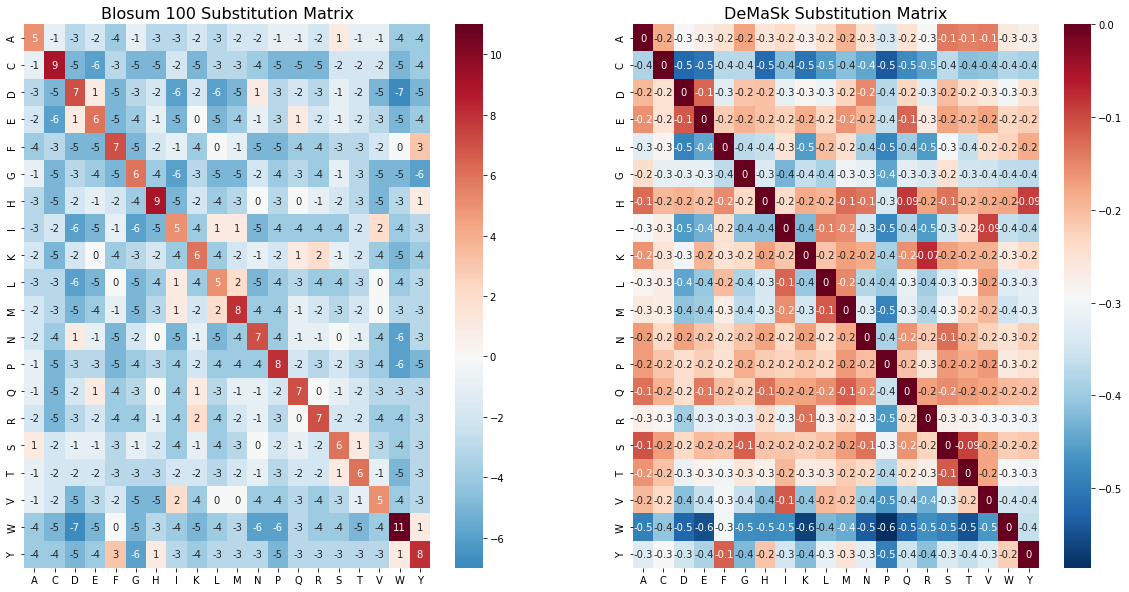

In [15]:
# BLOSUM SUBSTITUTION MATRICES

def get_sub_matrix(matrix_name="blosum100"):
    sub_matrix = getattr(MatrixInfo, matrix_name)
    sub_matrix.update({(k[1], k[0]):v for k,v in sub_matrix.items() if (k[1], k[0]) not in list(sub_matrix.keys())})
    return sub_matrix
sub_mat_b100 = get_sub_matrix("blosum100")
sub_mat_b80 = get_sub_matrix("blosum80")
sub_mat_b60 = get_sub_matrix("blosum60")
sub_mat_b40 = get_sub_matrix("blosum40")

# DEMASK SUBSTITUTION MATRICES
dff = pd.read_csv('../input/nesp-test-wildtype-pdb/matrix.txt', sep='\t')
letters = list( dff.columns )
l_dict = {x:y for x,y in zip(letters,range(20))}
sub_mat_demask = {}
for x in letters:
    for y in letters:
        sub_mat_demask[(x,y)] = dff.iloc[l_dict[x],l_dict[y]]

# PLOT MATRICES
AA = np.sort(list(aa_map.values()))
blosum100 = np.zeros((20,20))
demask = np.zeros((20,20))
for (k1,k2),v in sub_mat_b100.items():
    if (k1!='Z')&(k2!='Z')&(k1!='B')&(k2!='B')&(k1!='X')&(k2!='X'):
        blosum100[ aa_map_2[k1], aa_map_2[k2] ] = v
for (k1,k2),v in sub_mat_demask.items():
    if (k1!='Z')&(k2!='Z')&(k1!='B')&(k2!='B')&(k1!='X')&(k2!='X'):
        demask[ aa_map_2[k1], aa_map_2[k2] ] = v
        
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
sns.heatmap(blosum100, cmap='RdBu_r', annot=True, center=0.0)
plt.xticks(np.arange(20)+0.5,AA)
plt.yticks(np.arange(20)+0.5,AA)
plt.title('Blosum 100 Substitution Matrix',size=16)
plt.subplot(1,2,2)
sns.heatmap(demask, cmap='RdBu_r', annot=True, fmt='.1g') #, center=0.0)
plt.xticks(np.arange(20)+0.5,AA)
plt.yticks(np.arange(20)+0.5,AA)
plt.title('DeMaSk Substitution Matrix',size=16)
plt.show()

## Transformer ESM Features
In order to convert amino acid sequences aka proteins into meaningful features, we will use embeddings from SOTA protein transformer. We use Facebook's pretrained protein transformer ESM (Evolutionary Scale Modeling) with research paper [here][1] and GitHub [here][2]. Kaggleqrdl provided a starter notebook [here][3]. In version 15+, we also extract mutation probabilties and mutation entropy from ESM!

[1]: https://www.biorxiv.org/content/10.1101/622803v4
[2]: https://github.com/facebookresearch/esm
[3]: https://www.kaggle.com/code/kaggleqrdl/esm-quick-start-lb237

In [16]:
# https://github.com/facebookresearch/esm
!pip install fair-esm -q

# https://www.kaggle.com/code/kaggleqrdl/esm-quick-start-lb237
import torch, esm
token_map = {'L': 0, 'A': 1, 'G': 2, 'V': 3, 'S': 4, 'E': 5, 'R': 6, 'T': 7, 'I': 8, 'D': 9, 'P': 10, 
         'K': 11, 'Q': 12, 'N': 13, 'F': 14, 'Y': 15, 'M': 16, 'H': 17, 'W': 18, 'C': 19}
t_model, alphabet = esm.pretrained.esm2_t33_650M_UR50D()
batch_converter = alphabet.get_batch_converter()
t_model.eval()  # disables dropout for deterministic results
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
t_model.to(device)

Downloading: "https://dl.fbaipublicfiles.com/fair-esm/models/esm2_t33_650M_UR50D.pt" to /root/.cache/torch/hub/checkpoints/esm2_t33_650M_UR50D.pt
Downloading: "https://dl.fbaipublicfiles.com/fair-esm/regression/esm2_t33_650M_UR50D-contact-regression.pt" to /root/.cache/torch/hub/checkpoints/esm2_t33_650M_UR50D-contact-regression.pt


ESM2(
  (embed_tokens): Embedding(33, 1280, padding_idx=1)
  (layers): ModuleList(
    (0): TransformerLayer(
      (self_attn): MultiheadAttention(
        (k_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (v_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (q_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (out_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (rot_emb): RotaryEmbedding()
      )
      (self_attn_layer_norm): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
      (fc1): Linear(in_features=1280, out_features=5120, bias=True)
      (fc2): Linear(in_features=5120, out_features=1280, bias=True)
      (final_layer_norm): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
    )
    (1): TransformerLayer(
      (self_attn): MultiheadAttention(
        (k_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (v_proj): Linear(in_features=1280, out_features=1280, bia

### Embeddings
We input each train and test wildtype into our transformer and extract the last hidden layers activations. For each protein, this has shape `(1, len_protein_seq, 1280)`. We will save the full embeddings and the pooled embeddings for use later. Additionally we will save the MLM pretrain task amino acid prediction which indicates mutation probability and mutation entropy. This has shape `(1, len_protein_seq, 33)` but we extract to `(len_protein_seq, 20)` where 20 is number of common amino acids.

In [17]:
# TRAIN AND TEST WILDTYPES
PCA_CT = 16 # random sample size per protein to fit PCA with
all_pdb = [f for f in df.PDB.unique() if f not in bad]
base = 'VPVNPEPDATSVENVALKTGSGDSQSDPIKADLEVKGQSALPFDVDCWAILCKGAPNVLQRVNEKTKNSNRDRSGANKGPFKDPQKWGIKALPPKNPSWSAQDFKSPEEYAFASSLQGGTNAILAPVNLASQNSQGGVLNGFYSANKVAQFDPSKPQQTKGTWFQITKFTGAAGPYCKALGSNDKSVCDKNKNIAGDWGFDPAKWAYQYDEKNNKFNYVGK'
all_pdb_embed_pool = np.zeros((len(all_pdb)+1,1280))
all_pdb_embed_local = []
all_pdb_embed_tmp = []

from scipy.special import softmax 
from scipy.stats import entropy
all_pdb_prob = []

# EXTRACT TRANSFORMER EMBEDDINGS FOR TRAIN AND TEST WILDTYPES
print('Extracting embeddings from proteins...')
for i,p in enumerate(all_pdb+['TEST']):
    
    # WILDTYPE SEQUENCE
    print(p,', ',end='')
    if p=='TEST': seq = base
    else: seq = df.loc[df.PDB==p,'sequence'].iloc[0]
        
    # EXTRACT EMBEDDINGS, MUTATION PROBABILITIES, ENTROPY
    data = [("protein1", seq)]
    batch_labels, batch_strs, batch_tokens = batch_converter(data)
    batch_tokens = batch_tokens.to(device)
    with torch.no_grad():
        results = t_model(batch_tokens, repr_layers=[33])
    logits = (results['logits'].detach().cpu().numpy()[0,].T)[4:24,1:-1]
    all_pdb_prob.append(softmax(logits,axis=0))
    results = results["representations"][33].detach().cpu().numpy()
    
    # SAVE EMBEDDINGS
    all_pdb_embed_local.append(results)
    all_pdb_embed_pool[i,] = np.mean( results[0,:,:],axis=0 )
    
    # TEMPORARILY SAVE LOCAL MUTATION EMBEDDINGS
    tmp = df.loc[df.PDB==p,'position'].unique()
    if p=='TEST': tmp = np.random.choice(range(20,200),PCA_CT,replace=False)
    if len(tmp)>PCA_CT: tmp = np.random.choice(tmp,PCA_CT,replace=False)
    for j in tmp: all_pdb_embed_tmp.append( results[0,j,:] )
        
    del batch_tokens, results
    gc.collect(); torch.cuda.empty_cache()

all_pdb_embed_tmp = np.stack(all_pdb_embed_tmp)

Extracting embeddings from proteins...
1A43 , 1A5E , 1A7C , 1AAR , 1AG2 , 1AJ3 , 1AKK , 1AM7 , 1ANK , 1APS , 1ARR , 1AXB , 1AYF , 1AYI , 1AZP , 1B0O , 1B10 , 1BFG , 1BFM , 1BNI , 1BP2 , 1BPI , 1BTA , 1BU4 , 1BVC , 1BYW , 1C2R , 1C9O , 1CDC , 1CF3 , 1CHK , 1CQW , 1CSP , 1CYC , 1DIL , 1DIV , 1DKT , 1FKJ , 1FRD , 1FTG , 1FXA , 1G6N , 1G6P , 1H0C , 1H0X , 1H56 , 1H7M , 1HFY , 1HFZ , 1HME , 1HNG , 1HTI , 1HUE , 1IGV , 1IHB , 1IMQ , 1IO2 , 1IOB , 1IRO , 1ITM , 1JY0 , 1K5U , 1K9Q , 1KCQ , 1KFW , 1LS4 , 1LZ1 , 1M21 , 1M7T , 1MBG , 1MGR , 1MJ5 , 1MJC , 1MSI , 1N18 , 1N88 , 1NVO , 1O1U , 1OH0 , 1OIA , 1ONC , 1P2P , 1PDO , 1PFL , 1POH , 1PX0 , 1QGD , 1QLP , 1QM0 , 1QND , 1QQV , 1REI , 1RGG , 1RIL , 1RIS , 1ROP , 1RRO , 1RTB , 1RX4 , 1SHF , 1SHG , 1STN , 1SUP , 1TEN , 1TIT , 1TTG , 1TUP , 1TUX , 1UBQ , 1UWO , 1UZC , 1VII , 1VQB , 1W4E , 1W4H , 1WIT , 1XZO , 1Y4Y , 1Y9X , 1YYJ , 2A01 , 2A36 , 2ABD , 2AFG , 2AKY , 2BJD , 2C9Q , 2DRI , 2DVV , 2GNQ , 2HBB , 2HMB , 2HPR , 2IFB , 2IN9 , 2K3K , 2K7K , 2K

### RAPIDS PCA
The transformer embeddings have dimension 1280. Since we only have a few thousand rows of train data, that is too many features to include all of them in our XGB model. Furthermore, we want to use local, pooling, and delta embeddings. Which would be 3x1280. To prevent our model from overfitting as a result of the "curse of dimensionality", we reduce the dimension of embeddings using RAPIDS PCA. 

In [18]:
# REDUCE EMBEDDING DIM FROM 1280 TO 32 OR 16 WITH PCA
from cuml import PCA
pca_pool = PCA(n_components=32)
pca_embeds = pca_pool.fit_transform(all_pdb_embed_pool.astype('float32'))
pca_local = PCA(n_components=16)
pca_local.fit(all_pdb_embed_tmp.astype('float32'))
pdb_map = {x:y for x,y in zip(all_pdb,range(len(all_pdb)))}
pdb_map['kaggle'] = len(all_pdb)
del all_pdb_embed_tmp
_ = gc.collect()

## Feature Engineering Function

In [19]:
# FEATURE ENGINEER FUNCTION
def get_new_row(atom_df, j, row):
    ##################
    # ATOM_DF - IS PDB FILE'S ATOM_DF
    # J - IS RESIDUE NUMBER WHICH IS TRAIN CSV POSITION PLUS OFFSET
    # ROW - IS ROW FROM DOWNLOADED TRAIN CSV
    ##################
        
    dd = None
    tmp = atom_df.loc[(atom_df.residue_number==j)].reset_index(drop=True)
    prev = atom_df.loc[(atom_df.residue_number==j-1)].reset_index(drop=True)
    post = atom_df.loc[(atom_df.residue_number==j+1)].reset_index(drop=True)
    
    # FEATURE ENGINEER
    if len(tmp)>0:
        
        # GET MUTANT EMBEDDINGS
        data = [("protein1", row.mutant_seq)]
        batch_labels, batch_strs, batch_tokens = batch_converter(data)
        batch_tokens = batch_tokens.to(device)
        with torch.no_grad():
            results = t_model(batch_tokens, repr_layers=[33]) 
        results = results["representations"][33].cpu().numpy()
        mutant_local = pca_local.transform(results[:1,row.position,:])[0,]
        mutant_pool = np.mean( results[:1,:,:],axis=1 )
        mutant_pool = pca_pool.transform(mutant_pool)[0,]
    
        # MUTATION AND POSITION
        dd = {}
        dd['WT'] = row.wildtype
        dd['WT2'] = tmp.residue_name.map(aa_map)[0]
        dd['MUT'] = row.mutation
        dd['position'] = row.position
        dd['relative_position'] = row.position / len(row.sequence)

        # B_FACTOR
        if USE_B_COLUMN: dd['b_factor'] = tmp.b_factor.mean()
        
        # ANIMO ACID PROPERTIES AND DELTAS
        for c in PROPS:
            dd[f'{c}_1'] = aa_props.loc[row.wildtype,c]
            dd[f'{c}_2'] = aa_props.loc[row.mutation,c]
            dd[f'{c}_delta'] = dd[f'{c}_2']-dd[f'{c}_1']
            
        # SUBSTITUTION MATRICES
        dd['blosum100'] = sub_mat_b100[(row.wildtype,row.mutation)]
        dd['blosum80'] = sub_mat_b80[(row.wildtype,row.mutation)]
        dd['blosum60'] = sub_mat_b60[(row.wildtype,row.mutation)]
        dd['blosum40'] = sub_mat_b40[(row.wildtype,row.mutation)]
        dd['demask'] = sub_mat_demask[(row.wildtype,row.mutation)]

        # PREVIOUS AND POST AMINO ACID INFO
        if (len(prev)>0):
            dd['prev'] = prev.residue_name.map(aa_map)[0]
            if USE_B_COLUMN: dd['b_factor_prev'] = prev.b_factor.mean()
        else:
            dd['prev'] = 'X'
            if USE_B_COLUMN: dd['b_factor_prev'] = -999            
            
        if (len(post)>0):
            dd['post'] = post.residue_name.map(aa_map)[0]
            if USE_B_COLUMN: dd['b_factor_post'] = post.b_factor.mean() 
        else:
            dd['post'] = 'X'
            if USE_B_COLUMN: dd['b_factor_post'] = -999 
            
        # ANGLE BETWEEN MUTATION AND NEIGHBORS
        if (len(prev)>0)&(len(post)>0):
            # BACKBONE ATOMS
            atm = ['N','H','CA','O']
            prev = prev.loc[prev.atom_name.isin(atm)]
            tmp = tmp.loc[tmp.atom_name.isin(atm)]
            post = post.loc[post.atom_name.isin(atm)]
            # VECTORS
            c_prev = np.array( [prev.x_coord.mean(),prev.y_coord.mean(),prev.z_coord.mean()] )
            c_tmp = np.array( [tmp.x_coord.mean(),tmp.y_coord.mean(),tmp.z_coord.mean()] )
            c_post = np.array( [post.x_coord.mean(),post.y_coord.mean(),post.z_coord.mean()] )
            vec_a = c_prev - c_tmp
            vec_b = c_post - c_tmp
            # COMPUTE ANGLE
            norm_a = np.sqrt(vec_a.dot(vec_a))
            norm_b = np.sqrt(vec_b.dot(vec_b))
            dd['cos_angle'] = vec_a.dot(vec_b)/norm_a/norm_b
        else:
            dd['cos_angle'] = -2
            
        # 3D LOCATION OF MUTATION
        atm = ['N','H','CA','O']
        atoms = atom_df.loc[atom_df.atom_name.isin(atm)]
        centroid1 = np.array( [atoms.x_coord.mean(),atoms.y_coord.mean(),atoms.z_coord.mean()] )
        tmp = tmp.loc[tmp.atom_name.isin(atm)]
        centroid2 = np.array( [tmp.x_coord.mean(),tmp.y_coord.mean(),tmp.z_coord.mean()] )
        dist = centroid2 - centroid1
        dd['location3d'] = dist.dot(dist)
        
        # TRANSFORMER ESM EMBEDDINGS
        wt_local = pca_local.transform(all_pdb_embed_local[pdb_map[row.PDB]][:1,row.position,:])[0,]
        wt_pool = pca_embeds[pdb_map[row.PDB],]
        for kk in range(32):
            dd[f'pca_pool_{kk}'] = mutant_pool[kk] - wt_pool[kk]
            if kk>=16: continue
            dd[f'pca_wt_{kk}'] = wt_local[kk]
            dd[f'pca_mutant_{kk}'] = mutant_local[kk]
            dd[f'pca_local_{kk}'] = mutant_local[kk] - wt_local[kk]
            
        # TRANSFORMER MUTATION PROBS AND ENTROPY
        dd['mut_prob'] = all_pdb_prob[pdb_map[row.PDB]][token_map[dd['MUT']],dd['position']-1]
        dd['mut_entropy'] = entropy( all_pdb_prob[pdb_map[row.PDB]][:,dd['position']-1] )
        
        # SURFACE AREA FEATURES
        PATH = '../input/nesp-kaggle-train-surface-area/'
        if row.CIF: 
            nm = f'{row.CIF}-model_v3.csv'
        elif row.PDB!='kaggle': 
            PATH = '../input/nesp-jin-external-surface-area/'
            nm = f'{row.PDB}.csv'
        else: 
            nm = 'wildtype_structure_prediction_af2_SASA.csv'
        try:    
            area = pd.read_csv(f'{PATH}{nm}')
            rw = area.loc[area.Residue_number==j].iloc[0]
            dd['sa_total'] = rw.Total
            dd['sa_apolar'] = rw.Apolar
            dd['sa_backbone'] = rw.Backbone
            dd['sa_sidechain'] = rw.Sidechain
            dd['sa_ratio'] = rw.Ratio
            dd['sa_in/out'] = -1
            if rw['In/Out']=='i': dd['sa_in/out'] = 1
            elif rw['In/Out']=='o': dd['sa_in/out'] = 0
        except:
            print('### NEED SURFACE AREA for PDB:',row.PDB,'residue_number:',j)
            return None
        
        # LABEL ENCODE AMINO ACIDS
        dd['AA1'] = aa_map_2[dd['WT']]
        dd['AA2'] = aa_map_2[dd['MUT']]
        dd['AA3'] = aa_map_2[dd['prev']]
        dd['AA4'] = aa_map_2[dd['post']]
        
        # TARGETS AND SOURCES
        dd['ddG'] = row.ddG
        dd['dTm'] = row.dTm
        dd['pdb'] = row.PDB
        dd['source'] = row.source
        
        del batch_tokens, results, mutant_local, mutant_pool, wt_local, wt_pool
        gc.collect(); torch.cuda.empty_cache()

    return dd

# Transform Train Data

In [20]:
pdb = None
rows = []
offsets = []

for index,row in df.iterrows():
    if row.PDB in bad: continue
        
    # READ PDB FILE WHICH CONTAINS MORE INFO ABOUT PROTEIN
    first = False
    if row.PDB != pdb:
        pdb = row.PDB
        if row.CIF:
            atom_df = PandasMmcif().read_mmcif(f'../input/train-wildtypes-af/cif/{row.CIF}-model_v3.cif')
            atom_df = atom_df.df['ATOM']
            atom_df = atom_df.rename({'label_seq_id':'residue_number','label_comp_id':'residue_name'},axis=1)
            atom_df = atom_df.rename({'Cartn_x':'x_coord','Cartn_y':'y_coord','Cartn_z':'z_coord'},axis=1)
            atom_df = atom_df.rename({'B_iso_or_equiv':'b_factor','label_atom_id':'atom_name'},axis=1)
        else:
            atom_df = PandasPdb().read_pdb(f'downloaded_pdb/{row.PDB}.pdb')
            atom_df = atom_df.df['ATOM']
        first = True

    # VERY IMPORTANT - ALIGN SEQUENCES
    # THE RESIDUE NUMBERS IN PDB FILES DONT MATCH THE POSTION NUMBERS IN CSV FILE!
    tmp = atom_df.drop_duplicates(['residue_name','residue_number']).sort_values('residue_number')
    tmp = tmp.iloc[20:36].reset_index(drop=True)
    d = (tmp.residue_number.diff()!=1.0).sum()
    if d>1: print(f'=> ERROR missing consecutive amino acids in PDB file {row.PDB}')
    tmp['letter'] = tmp.residue_name.map(aa_map)  
    pdb_seq = (''.join( tmp.letter.values ))
    csv_seq = df.loc[df.PDB==row.PDB,'sequence'].values[0]
    i = csv_seq.find(pdb_seq)
    if i==-1: print('=> ERROR cannot find PDB sequence in CSV sequence for {row.PDB}')
    x = tmp.loc[0,'residue_number']
    offset = (x-i)-1
    if first: 
        print(f'{row.PDB} PDB residue_number equals {offset} added to position in CSV')
        dd = {}
        dd['pdb'] = row.PDB
        dd['offset'] = offset
        offsets.append(dd)
    
    # FEATURE ENGINEER
    j = row.position + offset
    dd = get_new_row(atom_df, j, row)
    if dd is not None:
        rows.append(dd)

1A43 PDB residue_number equals 147 added to position in CSV
1A5E PDB residue_number equals 0 added to position in CSV
1A7C PDB residue_number equals 1 added to position in CSV
1AAR PDB residue_number equals 0 added to position in CSV
1AG2 PDB residue_number equals 123 added to position in CSV
1AJ3 PDB residue_number equals 9 added to position in CSV
1AKK PDB residue_number equals 0 added to position in CSV
1AM7 PDB residue_number equals 1 added to position in CSV
1ANK PDB residue_number equals 0 added to position in CSV
1APS PDB residue_number equals 0 added to position in CSV
1ARR PDB residue_number equals 0 added to position in CSV
1AXB PDB residue_number equals 2 added to position in CSV
1AYF PDB residue_number equals 5 added to position in CSV
1AYI PDB residue_number equals 0 added to position in CSV
1AZP PDB residue_number equals 0 added to position in CSV
1B0O PDB residue_number equals 1 added to position in CSV
1B10 PDB residue_number equals 124 added to position in CSV
1BFG PDB

In [21]:
# ADD THESE OFFSETS TO CSV'S POSITION TO GET PDB'S RESIDUE NUMBER
offsets = pd.DataFrame(offsets)
offsets = offsets.loc[offsets.pdb.str[:2]!='GP'] # drop kaggle CIF
if len(offsets)>0:
    offsets.to_csv('downloaded_csv/PDB_offset_from_CSV.csv',index=False)
    print('Add these offsets to CSV position to get PDB residue number')
    display( offsets.head() )

Add these offsets to CSV position to get PDB residue number


,pdb,offset
0,1A43,147
1,1A5E,0
2,1A7C,1
3,1AAR,0
4,1AG2,123


# Create Train and Holdout
We create train and holdout datasets based on variables in code cell #1. We will rank normalize the targets so that the model so the model can train with data from different sources and all targets will look similar to the model.

In [22]:
# CREATE EXTERNAL TRAIN DATAFRAME
train = pd.DataFrame(rows)
train = train.loc[train.WT == train.WT2].reset_index(drop=True)
print('Train plus Holdout data shape', train.shape )
train['ct'] = train.groupby('pdb').WT.transform('count')
train = train.loc[train.ct>EXCLUDE_CT_UNDER].reset_index(drop=True)
train = train.drop(['WT2','ct'],axis=1)
print('Data shape after removing small mutation groups', train.shape )

Train plus Holdout data shape (6463, 146)
Data shape after removing small mutation groups (4944, 145)


In [23]:
# RANK NORMALIZE ddG AND dTm TARGETS SO ALL CAN BE MIXED TOGETHER
train['target'] = 0.5
for g in train.pdb.unique():
    target = 'dTm'
    tmp = train.loc[train.pdb==g,'dTm']
    if tmp.isna().sum()>len(tmp)/2: target = 'ddG'
    train.loc[train.pdb==g,'target'] =\
        rankdata(train.loc[train.pdb==g,target])/len(train.loc[train.pdb==g,target])
train.head()

,WT,MUT,position,relative_position,Molecular Weight_1,Molecular Weight_2,Molecular Weight_delta,Residue Weight_1,Residue Weight_2,Residue Weight_delta,pKa1_1,pKa1_2,pKa1_delta,pKb2_1,pKb2_2,pKb2_delta,pKx3_1,pKx3_2,pKx3_delta,pl4_1,pl4_2,pl4_delta,H_1,H_2,H_delta,VSC_1,VSC_2,VSC_delta,P1_1,P1_2,P1_delta,P2_1,P2_2,P2_delta,SASA_1,SASA_2,SASA_delta,NCISC_1,NCISC_2,NCISC_delta,blosum100,blosum80,blosum60,blosum40,demask,prev,post,cos_angle,location3d,pca_pool_0,pca_wt_0,pca_mutant_0,pca_local_0,pca_pool_1,pca_wt_1,pca_mutant_1,pca_local_1,pca_pool_2,pca_wt_2,pca_mutant_2,pca_local_2,pca_pool_3,pca_wt_3,pca_mutant_3,pca_local_3,pca_pool_4,pca_wt_4,pca_mutant_4,pca_local_4,pca_pool_5,pca_wt_5,pca_mutant_5,pca_local_5,pca_pool_6,pca_wt_6,pca_mutant_6,pca_local_6,pca_pool_7,pca_wt_7,pca_mutant_7,pca_local_7,pca_pool_8,pca_wt_8,pca_mutant_8,pca_local_8,pca_pool_9,pca_wt_9,pca_mutant_9,pca_local_9,pca_pool_10,pca_wt_10,pca_mutant_10,pca_local_10,pca_pool_11,pca_wt_11,pca_mutant_11,pca_local_11,pca_pool_12,pca_wt_12,pca_mutant_12,pca_local_12,pca_pool_13,pca_wt_13,pca_mutant_13,pca_local_13,pca_pool_14,pca_wt_14,pca_mutant_14,pca_local_14,pca_pool_15,pca_wt_15,pca_mutant_15,pca_local_15,pca_pool_16,pca_pool_17,pca_pool_18,pca_pool_19,pca_pool_20,pca_pool_21,pca_pool_22,pca_pool_23,pca_pool_24,pca_pool_25,pca_pool_26,pca_pool_27,pca_pool_28,pca_pool_29,pca_pool_30,pca_pool_31,mut_prob,mut_entropy,sa_total,sa_apolar,sa_backbone,sa_sidechain,sa_ratio,sa_in/out,AA1,AA2,AA3,AA4,ddG,dTm,pdb,source,target
0,H,A,1,0.010204,155.16,89.10,-66.06,137.14,71.08,-66.06,1.82,2.34,0.52,9.17,9.69,0.52,6.00,NaN,NaN,7.59,6.00,-1.59,-0.40,0.62,1.02,79.0,27.5,-51.5,10.4,8.1,-2.3,0.230,0.046,-0.184,2.025,1.181,-0.844,-0.010690,0.007187,0.017877,-3,-2,-2,-2,-0.1271,X,Q,-2.000000,428.159734,0.059647,-1.706213,-1.789394,-0.083181,-0.031327,-0.209708,-0.225682,-0.015973,0.014655,0.555739,0.128634,-0.427105,-0.017990,0.743646,0.688693,-0.054953,-0.020013,0.544727,0.146291,-0.398436,-0.011445,-0.682050,-1.116271,-0.434221,0.000779,0.010724,-0.133091,-0.143815,-0.013614,-0.034981,0.180194,0.215175,0.005026,0.027225,-0.937509,-0.964734,0.013670,0.039963,-0.385551,-0.425514,-0.017173,-0.245294,-0.530437,-0.285143,-0.006627,0.066019,0.099789,0.033771,0.007752,-0.474388,0.198008,0.672396,0.000904,-0.134462,0.018520,0.152982,-0.003660,0.378783,0.623410,0.244627,0.000164,-0.275364,-0.646168,-0.370804,-0.003722,0.012260,-0.008403,-0.005266,-0.009020,0.003361,-0.029209,0.007647,0.007314,0.005711,0.004538,-0.007070,0.007715,0.015640,0.001010,0.011139,0.022294,1.767246,161.56,110.83,40.10,121.46,78.6,0,6,0,20,13,0.5,NaN,1AJ3,jin_train.csv,0.962121
1,H,G,1,0.010204,155.16,75.07,-80.09,137.14,57.05,-80.09,1.82,2.34,0.52,9.17,9.60,0.43,6.00,NaN,NaN,7.59,5.97,-1.62,-0.40,0.48,0.88,79.0,0.0,-79.0,10.4,9.0,-1.4,0.230,0.000,-0.230,2.025,0.881,-1.144,-0.010690,0.179052,0.189742,-4,-3,-2,-2,-0.2352,X,Q,-2.000000,428.159734,0.070258,-1.706213,-2.019783,-0.313570,-0.006980,-0.209708,0.094914,0.304623,0.010339,0.555739,0.439233,-0.116506,-0.011585,0.743646,0.407195,-0.336452,-0.021346,0.544727,0.426300,-0.118427,-0.013376,-0.682050,-0.695021,-0.012971,-0.001845,0.010724,-0.161574,-0.172298,-0.011426,-0.034981,0.879486,0.914467,0.004423,0.027225,0.655501,0.628275,0.003307,0.039963,-0.641647,-0.681610,-0.009987,-0.245294,0.136802,0.382096,0.003115,0.066019,-0.166033,-0.232051,0.009215,-0.474388,-0.487715,-0.013326,0.009099,-0.134462,-0.034739,0.099723,-0.002819,0.378783,0.156531,-0.222253,-0.002148,-0.275364,-0.107002,0.168361,-0.006900,0.008734,-0.020732,-0.000696,-0.003806,-0.015211,-0.024021,0.002735,-0.007755,0.004004,0.013486,0.003154,0.004140,0.005726,0.008756,0.011527,0.012239,1.767246,161.56,110.83,40.10,121.46,78.6,0,6,5,20,13,-0.5,NaN,1AJ3,jin_train.csv,0.590909
2,F,A,3,0.030612,165.19,89.10,-76.09,147.18,71.08,-76.10,1.83,2.34,0.51,9.13,9.69,0.56,NaN,NaN,NaN,5.48,6.00,0.52,1.19,0.62,-0.57,115.5,27.5,-88.0,5.2,8.1,2.9,0.290,0.046,-0.244,2.228,1.181,-1.047,0.037552,0.007187,-0.030

In [24]:
# USE some sources TO TRAIN/VALIDATE AND other sources TO HOLDOUT VALIDATE
holdout = train.loc[train.source.isin(HOLDOUT_SOURCES)].reset_index(drop=True)
train = train.loc[train.source.isin(KFOLD_SOURCES)].reset_index(drop=True)

# LABEL ENCODE GROUPS FOR GROUP K FOLD
train['group'],_ = train.pdb.factorize()
holdout['group'],_ = holdout.pdb.factorize()

In [25]:
EXCLUDE = ['WT','MUT','prev','post','ddG','dTm','pdb','source','target','group','oof']
FEATURES = [c for c in train.columns if c not in EXCLUDE]
print(f'We have {len(FEATURES)} features for our model:')
print( FEATURES )

We have 137 features for our model:
['position', 'relative_position', 'Molecular Weight_1', 'Molecular Weight_2', 'Molecular Weight_delta', 'Residue Weight_1', 'Residue Weight_2', 'Residue Weight_delta', 'pKa1_1', 'pKa1_2', 'pKa1_delta', 'pKb2_1', 'pKb2_2', 'pKb2_delta', 'pKx3_1', 'pKx3_2', 'pKx3_delta', 'pl4_1', 'pl4_2', 'pl4_delta', 'H_1', 'H_2', 'H_delta', 'VSC_1', 'VSC_2', 'VSC_delta', 'P1_1', 'P1_2', 'P1_delta', 'P2_1', 'P2_2', 'P2_delta', 'SASA_1', 'SASA_2', 'SASA_delta', 'NCISC_1', 'NCISC_2', 'NCISC_delta', 'blosum100', 'blosum80', 'blosum60', 'blosum40', 'demask', 'cos_angle', 'location3d', 'pca_pool_0', 'pca_wt_0', 'pca_mutant_0', 'pca_local_0', 'pca_pool_1', 'pca_wt_1', 'pca_mutant_1', 'pca_local_1', 'pca_pool_2', 'pca_wt_2', 'pca_mutant_2', 'pca_local_2', 'pca_pool_3', 'pca_wt_3', 'pca_mutant_3', 'pca_local_3', 'pca_pool_4', 'pca_wt_4', 'pca_mutant_4', 'pca_local_4', 'pca_pool_5', 'pca_wt_5', 'pca_mutant_5', 'pca_local_5', 'pca_pool_6', 'pca_wt_6', 'pca_mutant_6', 'pca_local

# XGBoost Model

In [26]:
# LOAD XGB LIBRARY
from sklearn.model_selection import GroupKFold
from sklearn.metrics import mean_squared_error
import xgboost as xgb
print('XGB Version',xgb.__version__)

FOLDS = 11
SEED = 123

# XGB MODEL PARAMETERS
xgb_parms = { 
    'max_depth':4, 
    'learning_rate':0.001, 
    'subsample':0.6,
    'colsample_bytree':0.2, 
    'eval_metric':'rmse',
    'objective':'reg:squarederror',
    'tree_method':'gpu_hist',
    'predictor':'gpu_predictor',
    'random_state':SEED
}

XGB Version 1.6.2


In [27]:
%%time
importances = []
importances2 = []
oof = np.zeros(len(train))
preds = np.zeros(len(holdout))
os.system('mkdir xgb_models')

skf = GroupKFold(n_splits=FOLDS)
for fold,(train_idx, valid_idx) in enumerate(skf.split(
            train, train.target, train.group )):
        
    print('#'*25)
    print('### Fold',fold+1)
    print('### Train size',len(train_idx),'Valid size',len(valid_idx))
    print('#'*25)
    
    # TRAIN, VALID, HOLDOUT FOR FOLD K
    X_train = train.loc[train_idx, FEATURES]
    y_train = train.loc[train_idx,'target']
    X_valid = train.loc[valid_idx, FEATURES]
    y_valid = train.loc[valid_idx, 'target']
    X_holdout = holdout[FEATURES]
    
    dtrain = xgb.DMatrix(data=X_train, label=y_train)
    dvalid = xgb.DMatrix(data=X_valid, label=y_valid)
    dholdout = xgb.DMatrix(data=X_holdout)
    
    # TRAIN MODEL FOLD K
    model = xgb.train(xgb_parms, 
                dtrain=dtrain,
                evals=[(dtrain,'train'),(dvalid,'valid')],
                num_boost_round=9999,
                early_stopping_rounds=100,
                verbose_eval=100) 
    model.save_model(f'xgb_models/XGB_fold{fold}.xgb')
    
    # GET FEATURE IMPORTANCE FOR FOLD K
    dd = model.get_score(importance_type='weight')
    df = pd.DataFrame({'feature':dd.keys(),f'importance_{fold}':dd.values()})
    importances.append(df)
    dd = model.get_score(importance_type='gain')
    df = pd.DataFrame({'feature':dd.keys(),f'importance_{fold}':dd.values()})
    importances2.append(df)
            
    # INFER OOF FOLD K
    oof_preds = model.predict(dvalid)
    rsme = mean_squared_error(y_valid.values, oof_preds, squared=False)
    print('RSME =',rsme,'\n')
    oof[valid_idx] = oof_preds
    
    # HOLDOUT PREDS
    if len(holdout)>0:
        p = model.predict(dholdout)
        preds += p/FOLDS
    
    del dtrain, X_train, y_train, dd, df
    del X_valid, y_valid, dvalid, model
    _ = gc.collect()
    
print('#'*25)
rsme = mean_squared_error(train.target.values, oof, squared=False)
print('OVERALL RSME =',rsme,'\n')

train['oof'] = oof
if len(holdout)>0: holdout['preds'] = preds

#########################
### Fold 1
### Train size 3241 Valid size 526
#########################
[0]	train-rmse:0.28831	valid-rmse:0.28852
[100]	train-rmse:0.28263	valid-rmse:0.28221
[200]	train-rmse:0.27742	valid-rmse:0.27645
[300]	train-rmse:0.27273	valid-rmse:0.27138
[400]	train-rmse:0.26838	valid-rmse:0.26659
[500]	train-rmse:0.26435	valid-rmse:0.26220
[600]	train-rmse:0.26068	valid-rmse:0.25828
[700]	train-rmse:0.25726	valid-rmse:0.25477
[800]	train-rmse:0.25413	valid-rmse:0.25161
[900]	train-rmse:0.25118	valid-rmse:0.24860
[1000]	train-rmse:0.24845	valid-rmse:0.24578
[1100]	train-rmse:0.24591	valid-rmse:0.24328
[1200]	train-rmse:0.24353	valid-rmse:0.24113
[1300]	train-rmse:0.24127	valid-rmse:0.23900
[1400]	train-rmse:0.23917	valid-rmse:0.23719
[1500]	train-rmse:0.23720	valid-rmse:0.23552
[1600]	train-rmse:0.23527	valid-rmse:0.23383
[1700]	train-rmse:0.23345	valid-rmse:0.23230
[1800]	train-rmse:0.23171	valid-rmse:0.23094
[1900]	train-rmse:0.23008	valid-rmse:0.22964
[2000]	train-r

# Feature Importance
Below we display both XGB feature importance by `weight` and by `gain`.

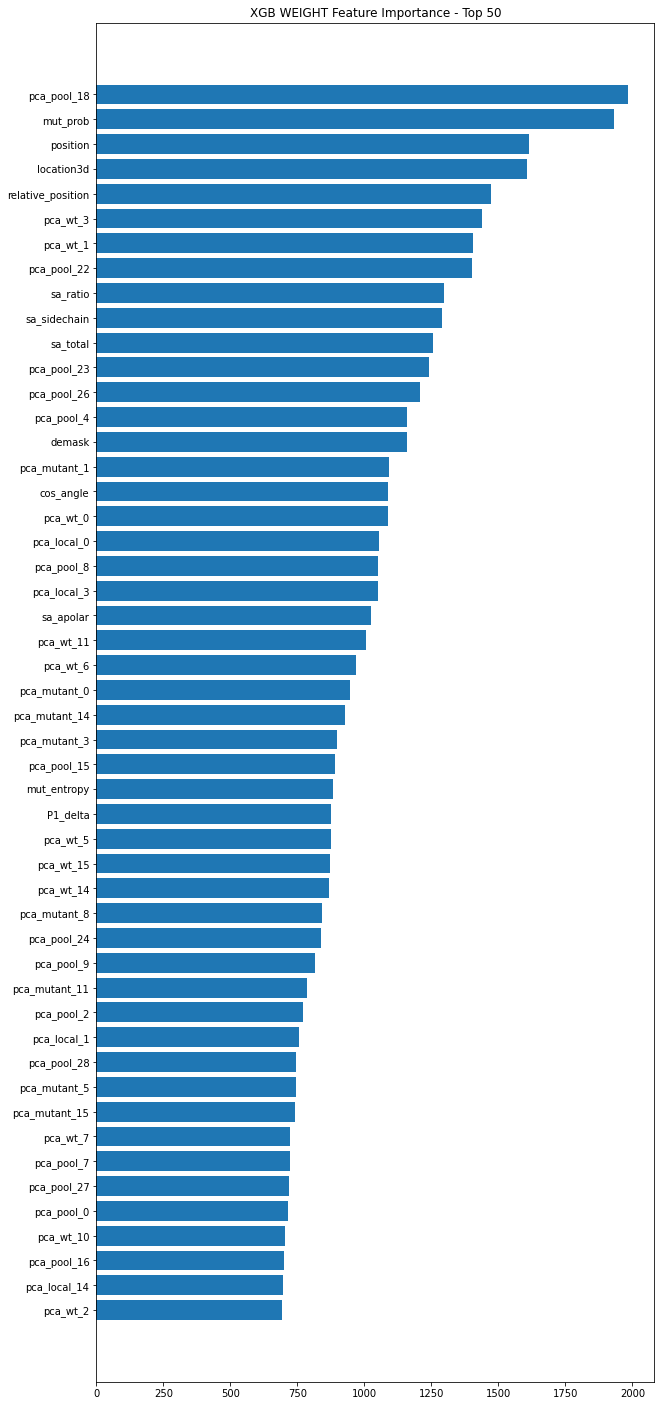

In [28]:
df = importances[0].copy()
for k in range(1,FOLDS): df = df.merge(importances[k], on='feature', how='left')
df['importance'] = df.iloc[:,1:].mean(axis=1)
df = df.sort_values('importance',ascending=False)
NUM_FEATURES = 50 #len(df)
plt.figure(figsize=(10,5*NUM_FEATURES//10))
plt.barh(np.arange(NUM_FEATURES,0,-1), df.importance.values[:NUM_FEATURES])
plt.yticks(np.arange(NUM_FEATURES,0,-1), df.feature.values[:NUM_FEATURES])
plt.title(f'XGB WEIGHT Feature Importance - Top {NUM_FEATURES}')
plt.show()

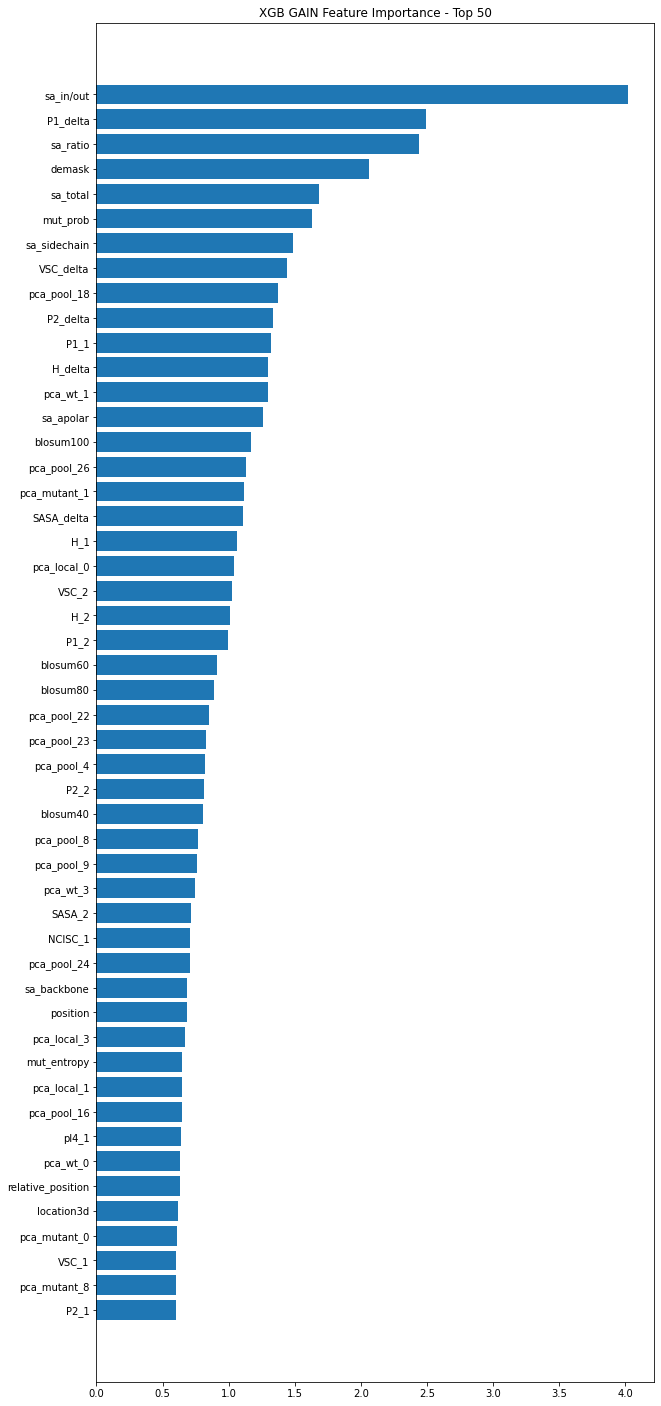

In [29]:
df = importances2[0].copy()
for k in range(1,FOLDS): df = df.merge(importances2[k], on='feature', how='left')
df['importance'] = df.iloc[:,1:].mean(axis=1)
df = df.sort_values('importance',ascending=False)
NUM_FEATURES = 50 #len(df)
plt.figure(figsize=(10,5*NUM_FEATURES//10))
plt.barh(np.arange(NUM_FEATURES,0,-1), df.importance.values[:NUM_FEATURES])
plt.yticks(np.arange(NUM_FEATURES,0,-1), df.feature.values[:NUM_FEATURES])
plt.title(f'XGB GAIN Feature Importance - Top {NUM_FEATURES}')
plt.show()

# Validate OOF (on either dTm or ddG)

In [30]:
sp = []; sp_dtm = []; sp_ddg = []
for p in train.pdb.unique():

    tmp = train.loc[train.pdb==p].reset_index(drop=True)
    ttarget = 'dTm'
    if tmp['dTm'].isna().sum()>len(tmp)/2: ttarget = 'ddG'
    print('Protein',p,'has mutation count =',len(tmp),'and target =',ttarget)
    r = np.abs( spearmanr(tmp.oof.values, tmp[ttarget].values).correlation )
    print('Spearman Metric =',r)
    sp.append(r)
    if ttarget=='dTm': sp_dtm.append(r)
    else: sp_ddg.append(r)
    print()

print('#'*25)
if len(sp_dtm)>0:
    print(f'Overall Spearman Metric (predicting dTm) =',np.nanmean(sp_dtm))
if len(sp_ddg)>0:
    print(f'Overall Spearman Metric (predicting ddG) =',np.nanmean(sp_ddg))

Protein 1AJ3 has mutation count = 66 and target = ddG
Spearman Metric = 0.7335599653520077

Protein 1APS has mutation count = 27 and target = ddG
Spearman Metric = 0.46144454375803845

Protein 1ARR has mutation count = 59 and target = ddG
Spearman Metric = 0.7309486721847334

Protein 1BNI has mutation count = 171 and target = ddG
Spearman Metric = 0.6864750865028888

Protein 1BPI has mutation count = 66 and target = ddG
Spearman Metric = 0.8113815054584025

Protein 1BU4 has mutation count = 71 and target = ddG
Spearman Metric = 0.7302484331253167

Protein 1BVC has mutation count = 73 and target = ddG
Spearman Metric = 0.7327511781313736

Protein 1CSP has mutation count = 50 and target = ddG
Spearman Metric = 0.6174457971959109

Protein 1FKJ has mutation count = 53 and target = ddG
Spearman Metric = 0.7959196056805525

Protein 1FTG has mutation count = 45 and target = ddG
Spearman Metric = 0.5284759052901536

Protein 1H7M has mutation count = 28 and target = ddG
Spearman Metric = 0.4113

# Validate Holdout (on either dTm or ddG)

In [31]:
sp = []; sp_dtm = []; sp_ddg = []
for p in holdout.pdb.unique():

    tmp = holdout.loc[holdout.pdb==p].reset_index(drop=True)
    ttarget = 'dTm'
    if tmp['dTm'].isna().sum()>len(tmp)/2: ttarget = 'ddG'
    print('Protein',p,'has mutation count =',len(tmp),'and target =',ttarget)
    r = np.abs( spearmanr(tmp.preds.values, tmp[ttarget].values).correlation )
    print('Spearman Metric =',r)
    sp.append(r)
    if ttarget=='dTm': sp_dtm.append(r)
    else: sp_ddg.append(r)
    print()

print('#'*25)
if len(sp_dtm)>0:
    print(f'Overall Spearman Metric (predicting dTm) =',np.nanmean(sp_dtm))
if len(sp_ddg)>0:
    print(f'Overall Spearman Metric (predicting ddG) =',np.nanmean(sp_ddg))

Protein GP01 has mutation count = 185 and target = dTm
Spearman Metric = 0.6766097467055034

Protein GP02 has mutation count = 211 and target = dTm
Spearman Metric = 0.710055769212217

Protein GP06 has mutation count = 56 and target = dTm
Spearman Metric = 0.16678797664338366

Protein GP07 has mutation count = 77 and target = dTm
Spearman Metric = 0.6078299643621575

Protein GP08 has mutation count = 55 and target = dTm
Spearman Metric = 0.29172068193218403

Protein GP09 has mutation count = 30 and target = dTm
Spearman Metric = 0.8728163388271348

Protein GP10 has mutation count = 84 and target = dTm
Spearman Metric = 0.5665299882920339

Protein GP11 has mutation count = 46 and target = dTm
Spearman Metric = 0.2355609507254659

Protein GP12 has mutation count = 78 and target = dTm
Spearman Metric = 0.6364947122449153

Protein GP14 has mutation count = 45 and target = dTm
Spearman Metric = 0.5796824572827513

Protein GP16 has mutation count = 33 and target = dTm
Spearman Metric = 0.753

# Transform Test Data
The PDB file provided by Kaggle does not contain real `b_factor`. The column labeled `b_factor` is actually `pLDDT` predicted by Alpha Fold. We will load a `PDF` file below of Kaggle's test protein with estimated `b_factor` downloaded from internet and provided by @kaggleqrdl and @ropeonmars described [here][1]. If we train with Alpha Fold PDB then we will load Kaggle's test PDB created by Alpha Fold.

[1]: https://www.kaggle.com/competitions/novozymes-enzyme-stability-prediction/discussion/356182#1968210

In [32]:
# LOAD TEST WILDTYPE
base = 'VPVNPEPDATSVENVALKTGSGDSQSDPIKADLEVKGQSALPFDVDCWAILCKGAPNVLQRVNEKTKNSNRDRSGANKGPFKDPQKWGIKALPPKNPSWSAQDFKSPEEYAFASSLQGGTNAILAPVNLASQNSQGGVLNGFYSANKVAQFDPSKPQQTKGTWFQITKFTGAAGPYCKALGSNDKSVCDKNKNIAGDWGFDPAKWAYQYDEKNNKFNYVGK'
len(base)

221

In [33]:
# LOAD TEST DATA
test = pd.read_csv('../input/novozymes-enzyme-stability-prediction/test.csv')
deletions = test.loc[test.protein_sequence.str.len()==220,'seq_id'].values
print('Test shape', test.shape )
test.head()

Test shape (2413, 4)


,seq_id,protein_sequence,pH,data_source
0,31390,VPVNPEPDATSVENVAEKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes
1,31391,VPVNPEPDATSVENVAKKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes
2,31392,VPVNPEPDATSVENVAKTGSGDSQSDPIKADLEVKGQSALPFDVDC...,8,Novozymes
3,31393,VPVNPEPDATSVENVALCTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes
4,31394,VPVNPEPDATSVENVALFTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes


In [34]:
# LOAD TEST DATA PDB FILE 
# NOTE KAGGLE'S PDB IS GENERATED BY ALPHA FOLD AND CONTAINS PLDDT IN B_FACTOR COLUMN
# WHEN TRAINING WITH KAGGLE.CSV WE NEED ALPHA FOLD PDB
# WHEN TRAINING WITH JIN DATA WE NEED PROTEIN DATA BANK PDB (with real b_factor)
if USE_PLDDT_INFER:
    atom_df = PandasPdb().read_pdb('../input/novozymes-enzyme-stability-prediction/wildtype_structure_prediction_af2.pdb')
else:
    atom_df = PandasPdb().read_pdb('../input/nesp-test-wildtype-pdb/model.pdb')
atom_df = atom_df.df['ATOM']
atom_df.head()

,record_name,atom_number,blank_1,atom_name,alt_loc,residue_name,blank_2,chain_id,residue_number,insertion,blank_3,x_coord,y_coord,z_coord,occupancy,b_factor,blank_4,segment_id,element_symbol,charge,line_idx
0,ATOM,1,,N,,VAL,,A,1,,,34.064,-6.456,50.464,1.0,42.82,10.46,,,NaN,2
1,ATOM,2,,H,,VAL,,A,1,,,33.576,-6.009,51.228,1.0,42.82,10.46,,,NaN,3
2,ATOM,3,,H2,,VAL,,A,1,,,33.882,-7.449,50.477,1.0,42.82,10.46,,,NaN,4
3,ATOM,4,,H3,,VAL,,A,1,,,35.060,-6.323,50.566,1.0,42.82,10.46,,,NaN,5
4,ATOM,5,,CA,,VAL,,A,1,,,33.643,-5.877,49.162,1.0,42.82,10.46,,,NaN,6


In [35]:
def get_test_mutation(row):
    for i,(a,b) in enumerate(zip(row.protein_sequence,base)):
        if a!=b: break
    row['wildtype'] = base[i]
    row['mutation'] = row.protein_sequence[i]
    row['position'] = i+1
    return row

# TRANSFORM TEST DATAFRAME TO MATCH TRAIN DATAFRAME
test = test.apply(get_test_mutation,axis=1)
test['ddG'] = np.nan
test['dTm'] = np.nan
test['CIF'] = None
test['sequence'] = base
test = test.rename({'protein_sequence':'mutant_seq'},axis=1)
test['source'] = 'kaggle'
test['PDB'] = 'kaggle'

# FEATURE ENGINEER TEST DATA
rows = []
print(f'Extracting embeddings and feature engineering {len(test)} test rows...')
for index,row in test.iterrows():
    if index%10==0: print(index,', ',end='')
    j = row.position
    dd = get_new_row(atom_df, j, row)
    rows.append(dd)
test = pd.DataFrame(rows)
test.head()

Extracting embeddings and feature engineering 2413 test rows...
0 , 10 , 20 , 30 , 40 , 50 , 60 , 70 , 80 , 90 , 100 , 110 , 120 , 130 , 140 , 150 , 160 , 170 , 180 , 190 , 200 , 210 , 220 , 230 , 240 , 250 , 260 , 270 , 280 , 290 , 300 , 310 , 320 , 330 , 340 , 350 , 360 , 370 , 380 , 390 , 400 , 410 , 420 , 430 , 440 , 450 , 460 , 470 , 480 , 490 , 500 , 510 , 520 , 530 , 540 , 550 , 560 , 570 , 580 , 590 , 600 , 610 , 620 , 630 , 640 , 650 , 660 , 670 , 680 , 690 , 700 , 710 , 720 , 730 , 740 , 750 , 760 , 770 , 780 , 790 , 800 , 810 , 820 , 830 , 840 , 850 , 860 , 870 , 880 , 890 , 900 , 910 , 920 , 930 , 940 , 950 , 960 , 970 , 980 , 990 , 1000 , 1010 , 1020 , 1030 , 1040 , 1050 , 1060 , 1070 , 1080 , 1090 , 1100 , 1110 , 1120 , 1130 , 1140 , 1150 , 1160 , 1170 , 1180 , 1190 , 1200 , 1210 , 1220 , 1230 , 1240 , 1250 , 1260 , 1270 , 1280 , 1290 , 1300 , 1310 , 1320 , 1330 , 1340 , 1350 , 1360 , 1370 , 1380 , 1390 , 1400 , 1410 , 1420 , 1430 , 1440 , 1450 , 1460 , 1470 , 1480 , 1490

,WT,WT2,MUT,position,relative_position,Molecular Weight_1,Molecular Weight_2,Molecular Weight_delta,Residue Weight_1,Residue Weight_2,Residue Weight_delta,pKa1_1,pKa1_2,pKa1_delta,pKb2_1,pKb2_2,pKb2_delta,pKx3_1,pKx3_2,pKx3_delta,pl4_1,pl4_2,pl4_delta,H_1,H_2,H_delta,VSC_1,VSC_2,VSC_delta,P1_1,P1_2,P1_delta,P2_1,P2_2,P2_delta,SASA_1,SASA_2,SASA_delta,NCISC_1,NCISC_2,NCISC_delta,blosum100,blosum80,blosum60,blosum40,demask,prev,post,cos_angle,location3d,pca_pool_0,pca_wt_0,pca_mutant_0,pca_local_0,pca_pool_1,pca_wt_1,pca_mutant_1,pca_local_1,pca_pool_2,pca_wt_2,pca_mutant_2,pca_local_2,pca_pool_3,pca_wt_3,pca_mutant_3,pca_local_3,pca_pool_4,pca_wt_4,pca_mutant_4,pca_local_4,pca_pool_5,pca_wt_5,pca_mutant_5,pca_local_5,pca_pool_6,pca_wt_6,pca_mutant_6,pca_local_6,pca_pool_7,pca_wt_7,pca_mutant_7,pca_local_7,pca_pool_8,pca_wt_8,pca_mutant_8,pca_local_8,pca_pool_9,pca_wt_9,pca_mutant_9,pca_local_9,pca_pool_10,pca_wt_10,pca_mutant_10,pca_local_10,pca_pool_11,pca_wt_11,pca_mutant_11,pca_local_11,pca_pool_12,pca_wt_12,pca_mutant_12,pca_local_12,pca_pool_13,pca_wt_13,pca_mutant_13,pca_local_13,pca_pool_14,pca_wt_14,pca_mutant_14,pca_local_14,pca_pool_15,pca_wt_15,pca_mutant_15,pca_local_15,pca_pool_16,pca_pool_17,pca_pool_18,pca_pool_19,pca_pool_20,pca_pool_21,pca_pool_22,pca_pool_23,pca_pool_24,pca_pool_25,pca_pool_26,pca_pool_27,pca_pool_28,pca_pool_29,pca_pool_30,pca_pool_31,mut_prob,mut_entropy,sa_total,sa_apolar,sa_backbone,sa_sidechain,sa_ratio,sa_in/out,AA1,AA2,AA3,AA4,ddG,dTm,pdb,source
0,L,L,E,17,0.076923,131.18,147.13,15.95,113.16,129.12,15.96,2.36,2.19,-0.17,9.60,9.67,0.07,NaN,4.25,NaN,5.98,3.22,-2.76,1.06,-0.74,-1.80,93.5,62.0,-31.5,4.9,12.3,7.4,0.186,0.151,-0.035,1.931,1.862,-0.069,0.051672,0.006802,-0.044870,-5,-4,-3,-2,-0.4047,A,K,-0.507968,436.616963,0.022690,-3.564583,-3.994956,-0.430373,-0.037171,-0.464601,0.245195,0.709797,0.007048,1.748841,1.472941,-0.275900,0.010024,-3.592017,-3.271749,0.320268,-0.015767,-0.319974,-1.083434,-0.763461,-0.000636,0.358290,0.282814,-0.075477,0.007840,0.684114,0.045608,-0.638506,0.013990,1.129399,-0.378221,-1.507620,-0.006938,-1.425712,-0.734945,0.690766,-0.000922,0.166048,-0.515485,-0.681532,0.004027,-0.155019,0.144717,0.299736,0.010822,-0.593691,-0.658521,-0.064830,0.005959,-0.948598,0.095808,1.044406,-0.018688,0.064066,-0.530288,-0.594354,-0.022118,-1.033846,-0.537537,0.496309,-0.026615,-0.481137,0.389153,0.870290,-0.013532,-0.017394,-0.017583,0.024844,0.013989,0.012870,-0.009616,-0.003203,0.000114,0.001808,-0.006891,-0.001132,-0.026863,-0.003787,-0.023523,-0.001908,0.023200,1.745942,170.14,158.59,13.86,156.28,100.0,0,9,3,0,8,NaN,NaN,kaggle,kaggle
1,L,L,K,17,0.076923,131.18,146.19,15.01,113.16,128.18,15.02,2.36,2.18,-0.18,9.60,8.95,-0.65,NaN,10.53,NaN,5.98,9.74,3.76,1.06,-1.50,-2.56,93.5,100.0,6.5,4.9,11.3,6.4,0.186,0.219,0.033,1.931,2.258,0.327,0.051672,0.017708,-0.033964,-4,-3,-2,-2,-0.4034,A,K,-0.507968,436.616963,-0.008187,-3.564583,-4.030924,-0.466341,-0.009240,-0.464601,0.145982,0.610583,0.004540,1.748841,1.478215,-0.270626,0.005035,-3.592017,-3.310146,0.281871,-0.021705,-0.319974,-0.061284,0.258690,0.001668,0.358290,0.184871,-0.173420,0.021918,0.684114,-0.568273,-1.252386,0.016616,1.129399,0.463540,-0.665859,0.004960,-1.425712,-0.937722,0.487990,-0.012380,0.166048,-0.685878,-0.851926,-0.007495,-0.155019,0.249394,0.404412,0.010869,-0.593691,-0.986452,-0.392761,-0.001174,-0.948598,-0.031861,0.916737,0.011427,0.064066,-0.164638,-0.228704,0.010190,-1.033846,-0.825144,0.208702,0.007524,-0.481137,-0.107601,0.373536,0.000379,0.014209,-0.006896,0.005009,0.004662,-0.015761,-0.000365,-0.005142,-0.023275,-0.000400,-0.006226,-0.000112,0.002169,0.005795,-0.005478,-0.018756,0.036488,1.745942,170.14,158.59,13.86,156.28,100.0,0,9,8,0,8,NaN,NaN,kaggle,kaggle
2,L,L,K,17,0.076923,131.18,146.19,15.01,113.16,128.18,15.02,2.36,2.18,-0.18,9.60,8.95,-0.65,NaN,10.53,NaN,5.98,9.74,3.76,1.06,-1.50,-2.56,93.5,100.0,6.5,4.9,11.3,6.4,0.186,0.219,0.033,1.931,2.258,0.327,0.051672,0.017708,-0.033964,-4,-3,-2,

# Infer Test Data

In [36]:
%%time
# TEST DATA FOR XGB
X_test = test[FEATURES]
dtest = xgb.DMatrix(data=X_test)

# INFER XGB MODELS ON TEST DATA
model = xgb.Booster()
model.load_model(f'xgb_models/XGB_fold0.xgb')
preds = model.predict(dtest)
for f in range(1,FOLDS):
    model.load_model(f'xgb_models/XGB_fold{f}.xgb')
    preds += model.predict(dtest)
preds /= FOLDS

CPU times: user 1.73 s, sys: 32 ms, total: 1.77 s
Wall time: 1.77 s


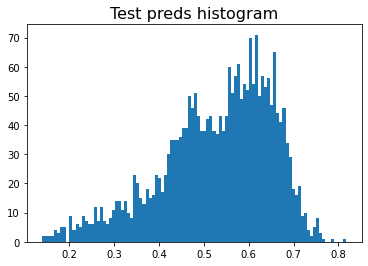

In [37]:
plt.hist(preds,bins=100)
plt.title('Test preds histogram',size=16)
plt.show()

# Create Submission CSV
There are 2413 rows in test data. Among these, 2336 that are `edit mutations` and 77 are `delete mutations`. Our trained model can only predict `edit mutations`, so will set all `delete mutations` to the mean `edit mutation` prediction below.

In [38]:
sub = pd.read_csv('../input/novozymes-enzyme-stability-prediction/sample_submission.csv')
sub.tm = preds
sub.loc[sub.seq_id.isin(deletions),'tm'] = sub.loc[~sub.seq_id.isin(deletions),'tm'].mean()
sub.to_csv(f'submission_ver{VER}.csv',index=False)
sub.head()

,seq_id,tm
0,31390,0.608652
1,31391,0.583849
2,31392,0.528280
3,31393,0.693516
4,31394,0.714240
